# Predicting Australian Car Price: ML and DL Approach
## Group - Sydney Group 9
### Yasin Hossain Onick - S371122
### Ferdous Shoheli - S371843

In [1]:
# Importing necessary libraries

# For data frames
import pandas as pd
import numpy as np

# For visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# For standardization
from sklearn.preprocessing import StandardScaler

# For feature engineering
import datetime

# For test-train split and hypertuning
from sklearn.model_selection import train_test_split, GridSearchCV

# For machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# For neural network models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, LSTM, SimpleRNN

# For model evaluation
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [2]:
# To not show any warnings
import warnings
warnings.filterwarnings('ignore')

# To show all columns
pd.set_option('display.max_columns', None)

#### Loading the Data

In [3]:
# Reading dataset into a DataFrame
df = pd.read_csv("Australian Vehicle Prices.csv", header=0)

# Showing number of records
print("Total Records: ", len(df))

# Showing first ten rows of data
print(df.head(10))

Total Records:  16734
           Brand    Year   Model               Car/Suv  \
0      Ssangyong  2022.0  Rexton  Sutherland Isuzu Ute   
1             MG  2022.0     MG3             Hatchback   
2            BMW  2022.0    430I                 Coupe   
3  Mercedes-Benz  2011.0    E500                 Coupe   
4        Renault  2022.0  Arkana                   SUV   
5         Toyota  2004.0  Estima        ON FOUR WHEELS   
6           Land  2017.0   Rover                   SUV   
7         Nissan  2000.0  Pulsar             Hatchback   
8         Toyota  2013.0      86                 Coupe   
9          Honda  2014.0    Jazz             Hatchback   

                                               Title UsedOrNew Transmission  \
0               2022 Ssangyong Rexton Ultimate (awd)      DEMO    Automatic   
1          2022 MG MG3 Auto Excite (with Navigation)      USED    Automatic   
2                              2022 BMW 430I M Sport      USED    Automatic   
3                   201

In [4]:
# Showing data type of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16734 entries, 0 to 16733
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand              16733 non-null  object 
 1   Year               16733 non-null  float64
 2   Model              16733 non-null  object 
 3   Car/Suv            16706 non-null  object 
 4   Title              16733 non-null  object 
 5   UsedOrNew          16733 non-null  object 
 6   Transmission       16733 non-null  object 
 7   Engine             16733 non-null  object 
 8   DriveType          16733 non-null  object 
 9   FuelType           16733 non-null  object 
 10  FuelConsumption    16733 non-null  object 
 11  Kilometres         16733 non-null  object 
 12  ColourExtInt       16733 non-null  object 
 13  Location           16284 non-null  object 
 14  CylindersinEngine  16733 non-null  object 
 15  BodyType           16452 non-null  object 
 16  Doors              151

#### Data Preparation

In [5]:
# Removing extra columns with repeatative info
df.drop(['Model', 'Car/Suv', 'Title'],axis=1,inplace=True)

# Replacing ambiguous info with null value
df.replace(['-', '- / -', 'POA'],np.NAN,inplace=True)

In [6]:
# Find missing value for each column and their percentages compared to total dataset 
missing_values = df.isnull().sum()
total_rows = len(df)
missing_percentages = (missing_values / total_rows) * 100

# Combining the count of missing values and their percentages
missing_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage of Total': missing_percentages
})

# Displaying the summary
print(missing_summary)

                   Missing Values  Percentage of Total
Brand                           1             0.005976
Year                            1             0.005976
UsedOrNew                       1             0.005976
Transmission                  252             1.505916
Engine                       1675            10.009561
DriveType                       1             0.005976
FuelType                      638             3.812597
FuelConsumption              1698            10.147006
Kilometres                    592             3.537708
ColourExtInt                  360             2.151309
Location                      450             2.689136
CylindersinEngine            1675            10.009561
BodyType                      282             1.685192
Doors                        1604             9.585275
Seats                        1705            10.188837
Price                          53             0.316720


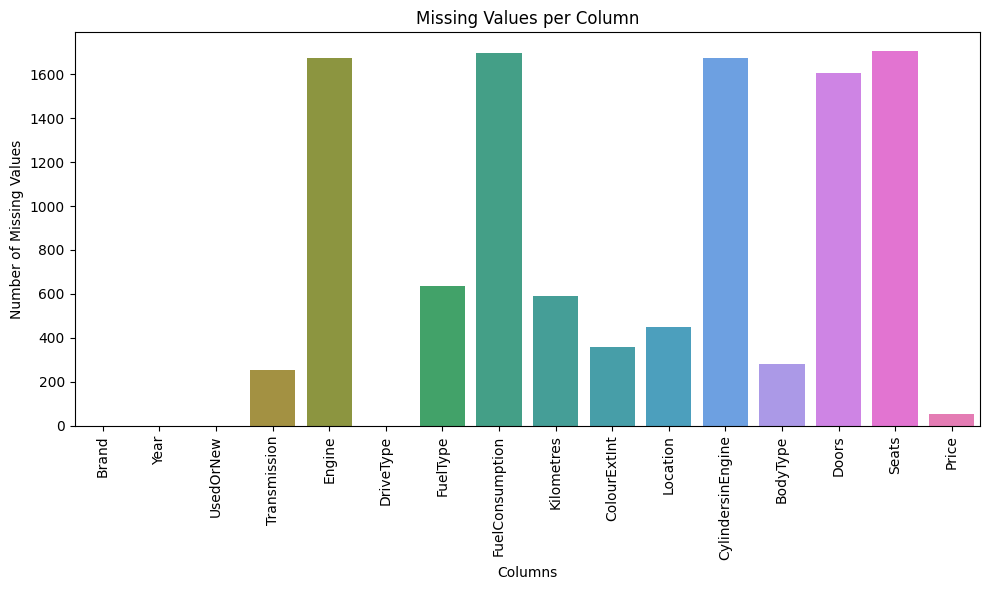

In [7]:
# Plotting the missing values for each column
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_values.index, y=missing_values.values, hue=missing_values.index)
plt.xticks(rotation=90)
plt.title('Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.tight_layout()
plt.show()

In [8]:
# Dropping rows with missing target values
df.dropna(subset=['Price'], inplace=True)

# Dropping rows with more than one-third missing values
threshold = len(df.columns) // 3
df.dropna(thresh=threshold, inplace=True)

# Checking missing value in dataset
print(df.isnull().sum())

Brand                   0
Year                    0
UsedOrNew               0
Transmission          243
Engine               1658
DriveType               0
FuelType              632
FuelConsumption      1681
Kilometres            575
ColourExtInt          356
Location              449
CylindersinEngine    1658
BodyType              279
Doors                1587
Seats                1688
Price                   0
dtype: int64


In [9]:
# Extracting only useful parts from the selected columns
df['Engine'] = df['Engine'].str.split(',').str[1].str.split().str[0]
df['FuelConsumption'] = df['FuelConsumption'].str.split('/').str[0].str.split().str[0]
df['ColourExtInt'] = df['ColourExtInt'].str.split('/').str[0].str.strip()
df['Location'] = df['Location'].str.split(',').str[1].str.strip()
df['CylindersinEngine'] = df['CylindersinEngine'].str.split().str[0]
df['Doors'] = df['Doors'].str.split().str[0]
df['Seats'] = df['Seats'].str.split().str[0]

# Renaming the columns appropriately 
df.rename(columns={'Engine': 'EngineSize'}, inplace=True)
df.rename(columns={'FuelConsumption': 'FuelPer100km'}, inplace=True)
df.rename(columns={'ColourExtInt': 'ColourExt'}, inplace=True)

# Removing newly-generated ambiguous info
df.replace(['-',],np.NAN,inplace=True)

# Checking for missing values again
print(df.isnull().sum())

Brand                   0
Year                    0
UsedOrNew               0
Transmission          243
EngineSize           1766
DriveType               0
FuelType              632
FuelPer100km         1681
Kilometres            575
ColourExt             392
Location              449
CylindersinEngine    1658
BodyType              279
Doors                1587
Seats                1688
Price                   0
dtype: int64


In [10]:
# Dropping rows when missing data in a column is small
df.dropna(subset=['Brand', 'Year', 'UsedOrNew', 'Transmission', 'DriveType', 'FuelType', 'Kilometres', 
                  'ColourExt', 'Location', 'BodyType'], inplace=True)

# Imputing rows with mode when missing data in a column is high 
df['EngineSize'] = df.groupby('BodyType')['EngineSize'].transform(lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x)
df['FuelPer100km'] = df.groupby('EngineSize')['FuelPer100km'].transform(lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x)
df['CylindersinEngine'] = df.groupby('EngineSize')['CylindersinEngine'].transform(lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x)
df['Doors'] = df.groupby('BodyType')['Doors'].transform(lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x)
df['Seats'] = df.groupby('BodyType')['Seats'].transform(lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x)

# Checking the results after imputation
print(df.isnull().sum())

Brand                0
Year                 0
UsedOrNew            0
Transmission         0
EngineSize           0
DriveType            0
FuelType             0
FuelPer100km         0
Kilometres           0
ColourExt            0
Location             0
CylindersinEngine    0
BodyType             0
Doors                0
Seats                0
Price                0
dtype: int64


In [11]:
# Changing the datatype of modified columns
df['Year'] = df['Year'].astype(int)
df['EngineSize'] = df['EngineSize'].astype(float)
df['FuelPer100km'] = df['FuelPer100km'].astype(float)
df['Kilometres'] = df['Kilometres'].astype(float)
df['CylindersinEngine'] = df['CylindersinEngine'].astype(int)
df['Doors'] = df['Doors'].astype(int)
df['Seats'] = df['Seats'].astype(int)
df['Price'] = df['Price'].astype(float)

# Showing datatype of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14941 entries, 0 to 16733
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand              14941 non-null  object 
 1   Year               14941 non-null  int32  
 2   UsedOrNew          14941 non-null  object 
 3   Transmission       14941 non-null  object 
 4   EngineSize         14941 non-null  float64
 5   DriveType          14941 non-null  object 
 6   FuelType           14941 non-null  object 
 7   FuelPer100km       14941 non-null  float64
 8   Kilometres         14941 non-null  float64
 9   ColourExt          14941 non-null  object 
 10  Location           14941 non-null  object 
 11  CylindersinEngine  14941 non-null  int32  
 12  BodyType           14941 non-null  object 
 13  Doors              14941 non-null  int32  
 14  Seats              14941 non-null  int32  
 15  Price              14941 non-null  float64
dtypes: float64(4), int32(4), ob

#### EDA

In [12]:
# Showing the descriptive statistics
print(df.describe())

               Year    EngineSize  FuelPer100km     Kilometres  \
count  14941.000000  14941.000000  14941.000000   14941.000000   
mean    2016.079312      2.397671      7.732354  100358.207483   
std        4.975422      0.841523      2.134969   77589.621161   
min     1959.000000      0.700000      0.000000       1.000000   
25%     2013.000000      2.000000      6.700000   42312.000000   
50%     2017.000000      2.100000      7.500000   85742.000000   
75%     2020.000000      2.800000      8.600000  146118.000000   
max     2023.000000      7.300000     27.000000  533849.000000   

       CylindersinEngine         Doors         Seats         Price  
count       14941.000000  14941.000000  14941.000000  1.494100e+04  
mean            4.397497      4.027240      5.076166  3.519513e+04  
std             1.070609      0.685473      1.110234  3.177716e+04  
min             0.000000      2.000000      2.000000  8.800000e+01  
25%             4.000000      4.000000      5.000000  1.8990

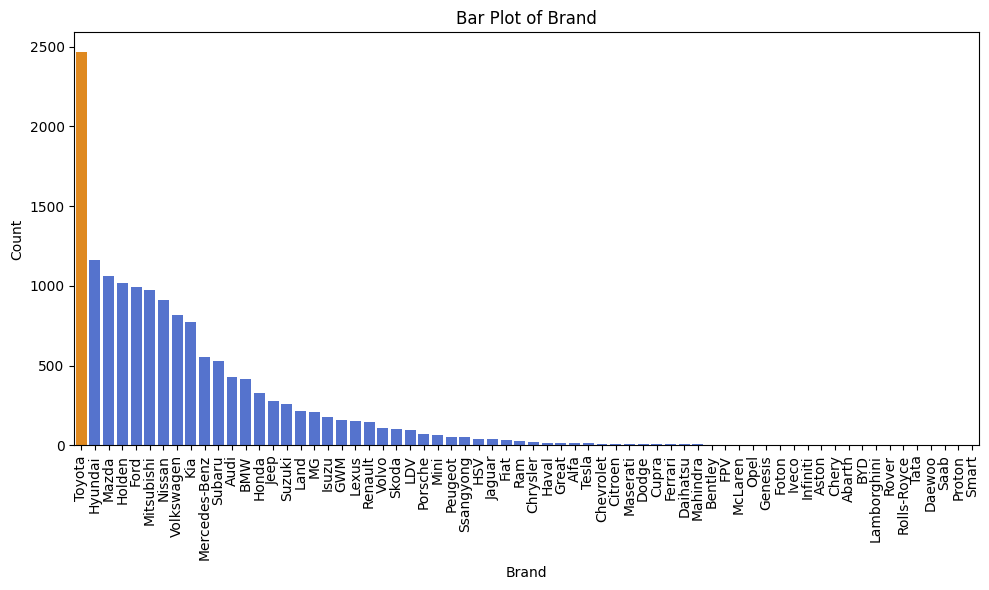

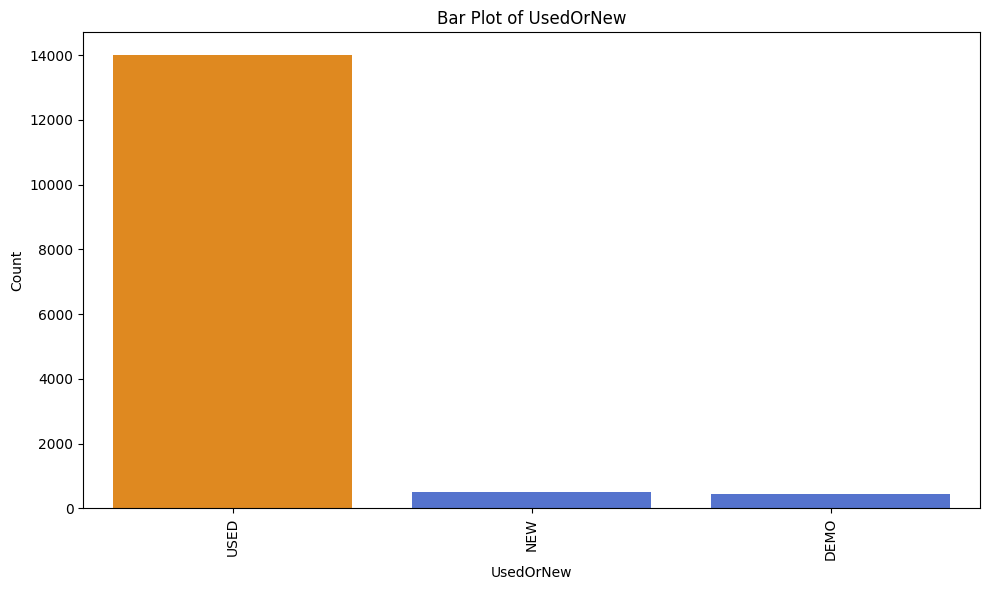

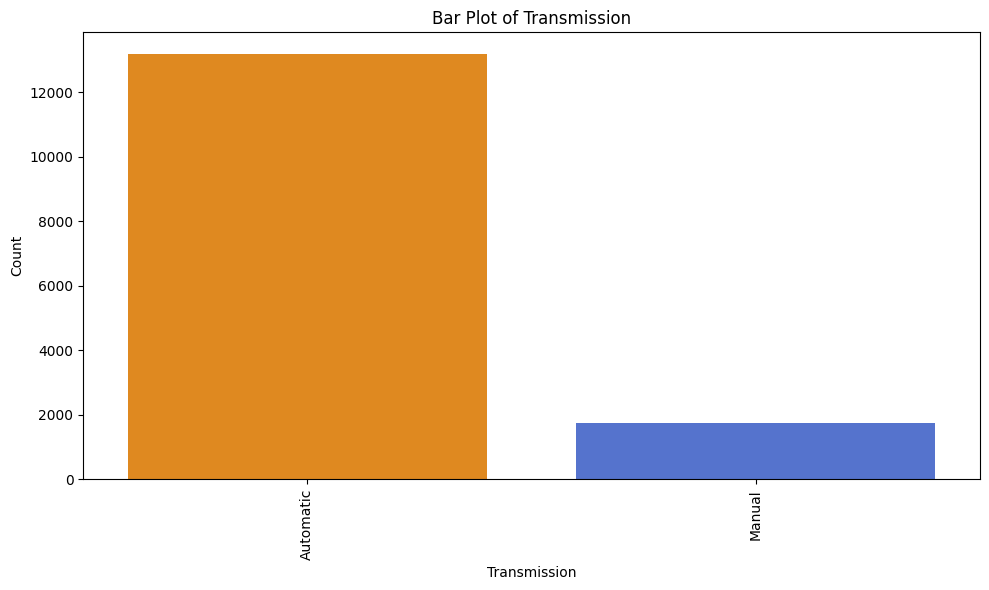

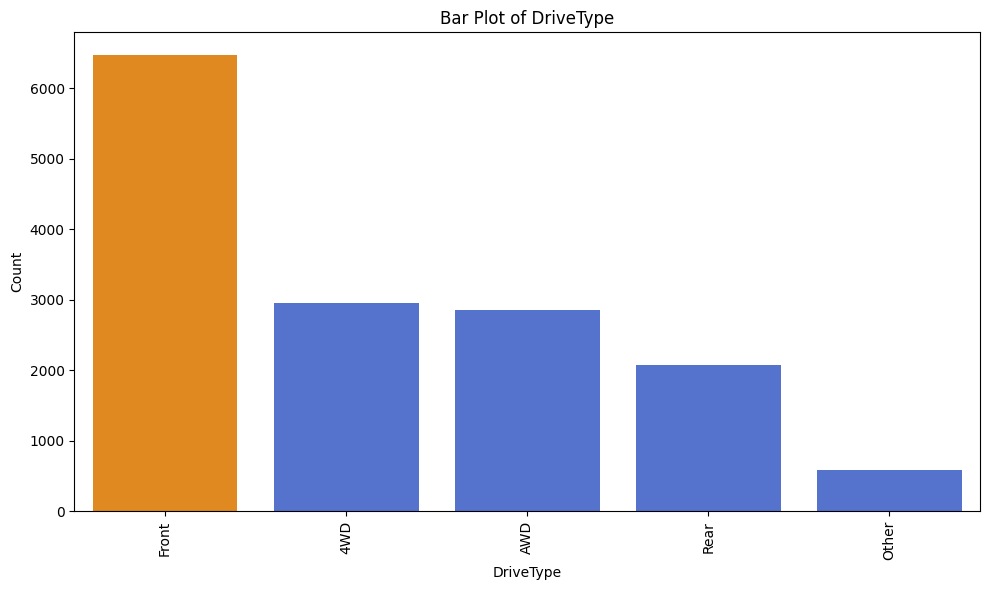

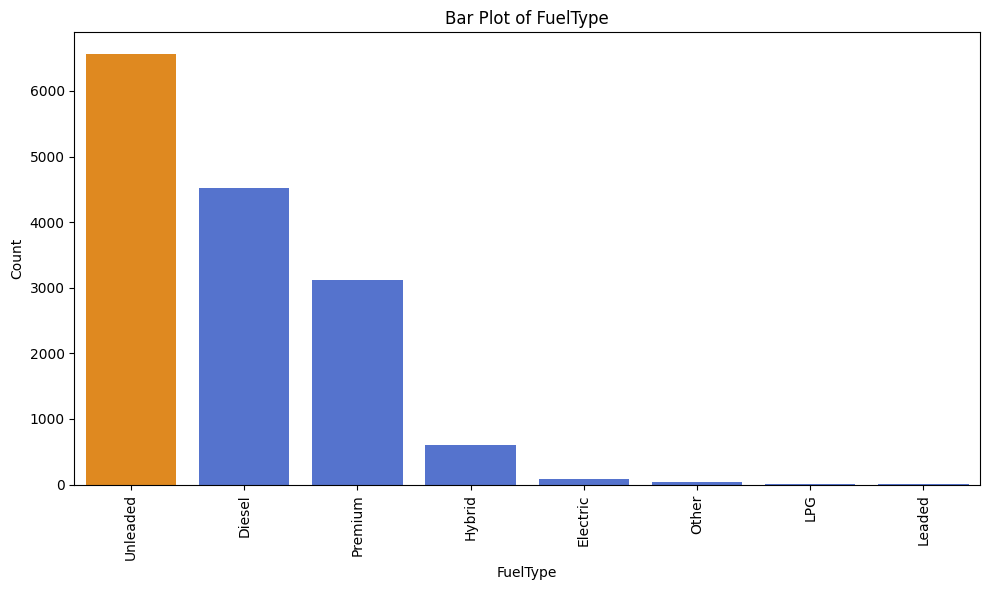

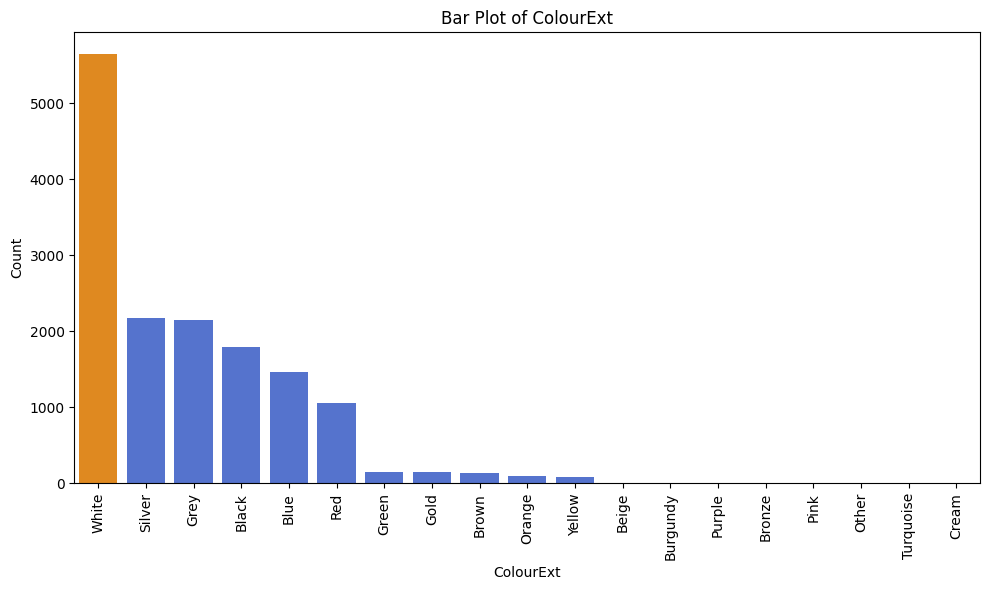

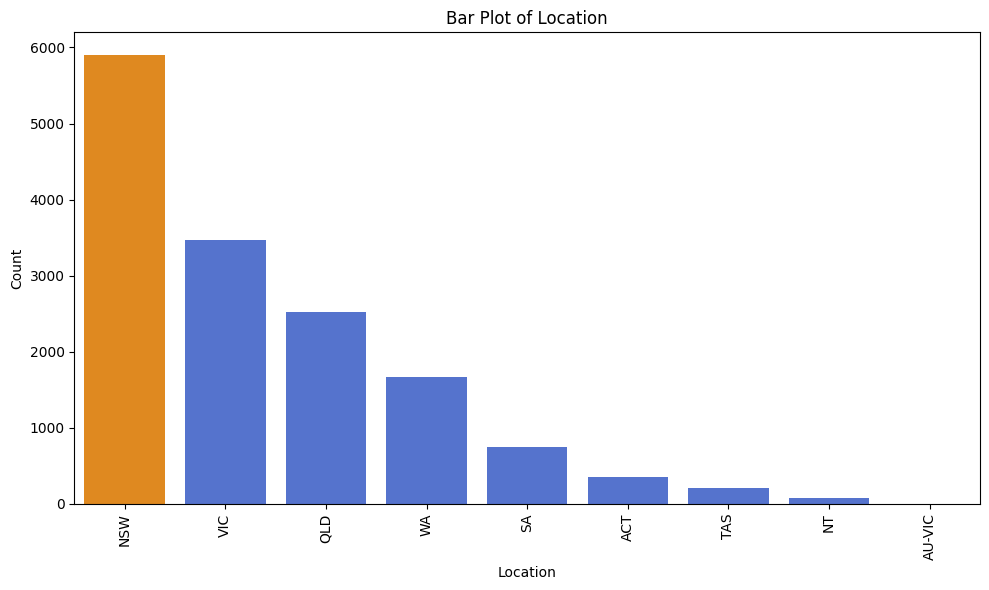

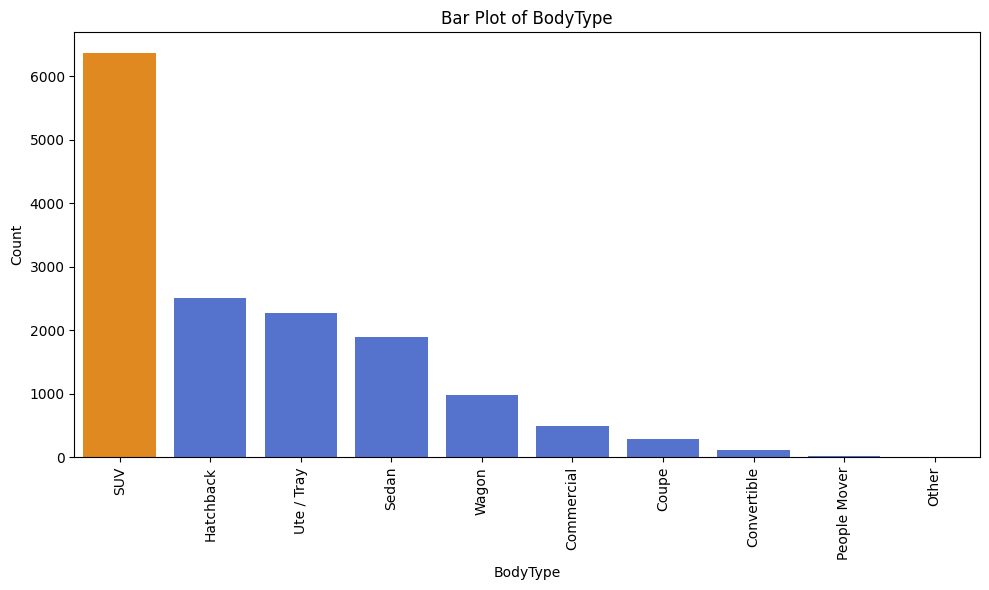

In [13]:
# Identifying categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Plotting bar plots for each categorical column
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    
    # Getting the counts of each category in the column
    counts = df[col].value_counts()
    
    # Assigning color 'royalblue' for all bars, and 'darkorange' for the highest bar
    bar_colors = ['darkorange' if count == counts.max() else 'royalblue' for count in counts]
    
    # Creating a count plot with custom colors
    sns.barplot(x=counts.index, y=counts.values, palette=bar_colors)
    plt.title(f'Bar Plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

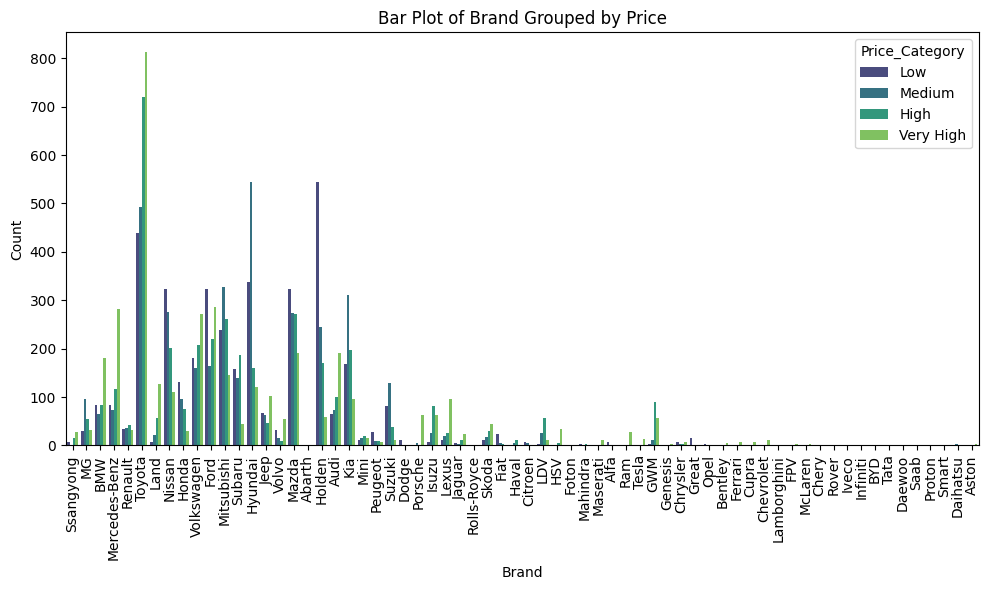

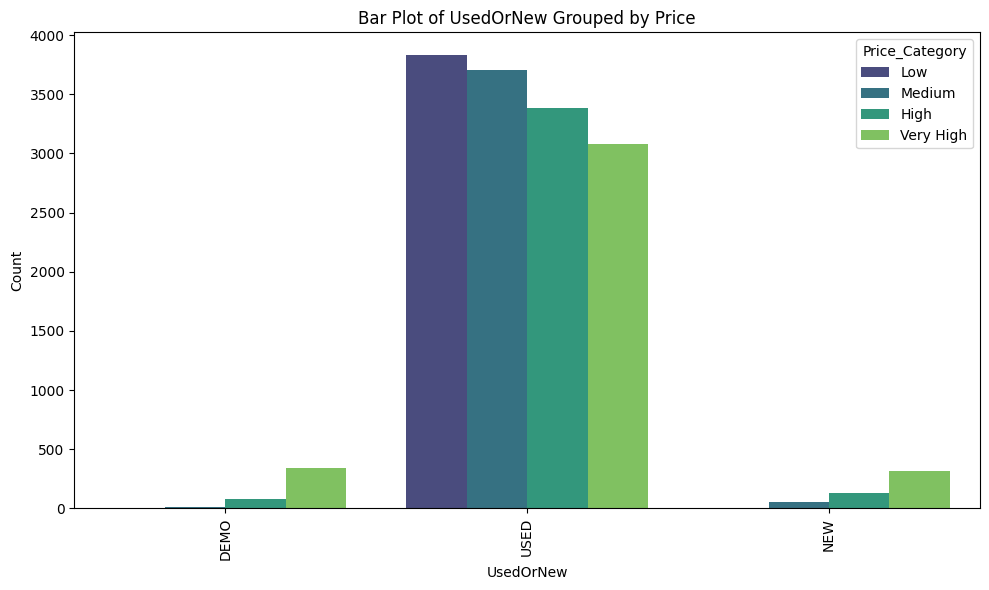

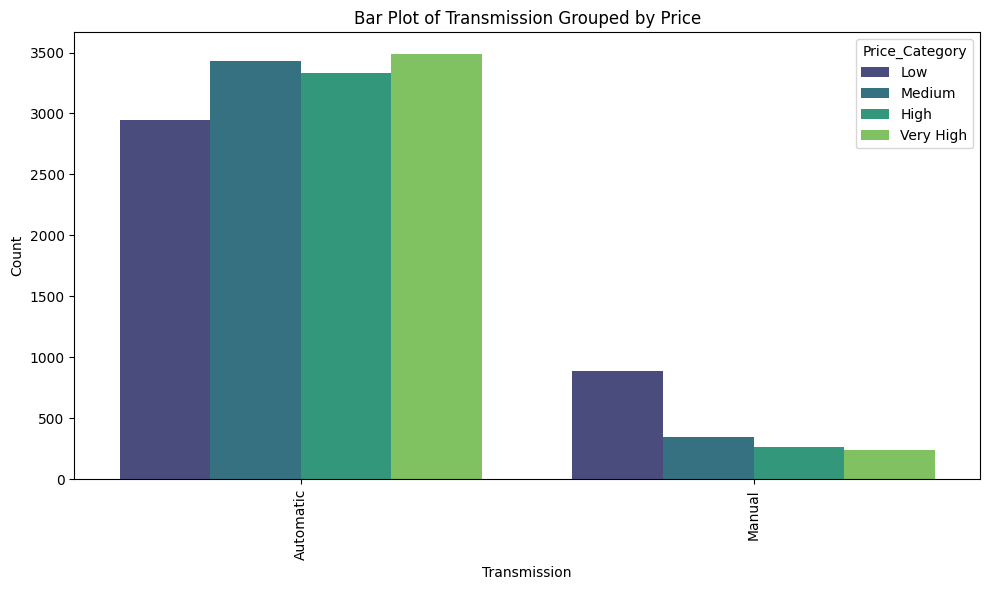

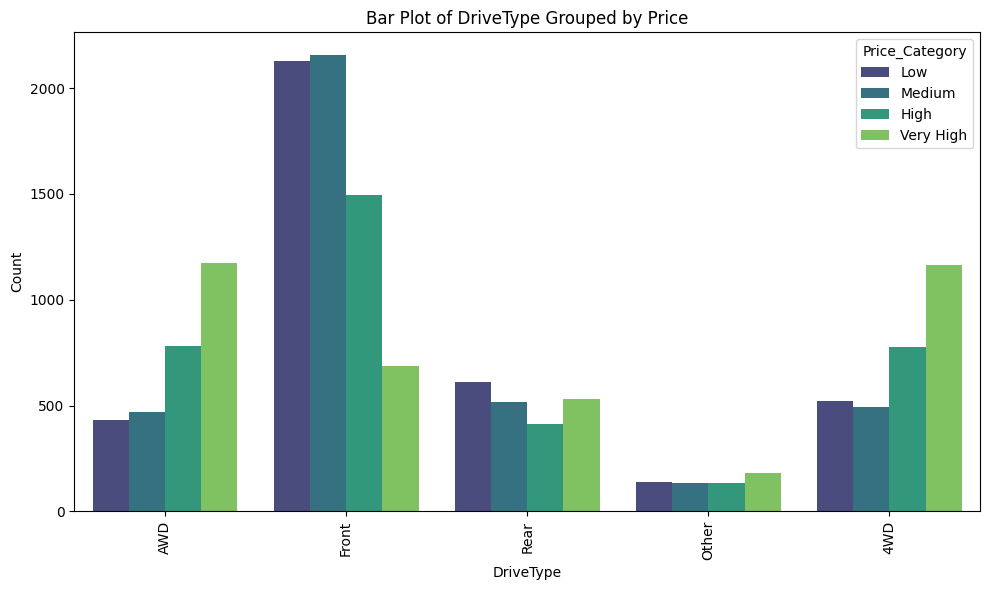

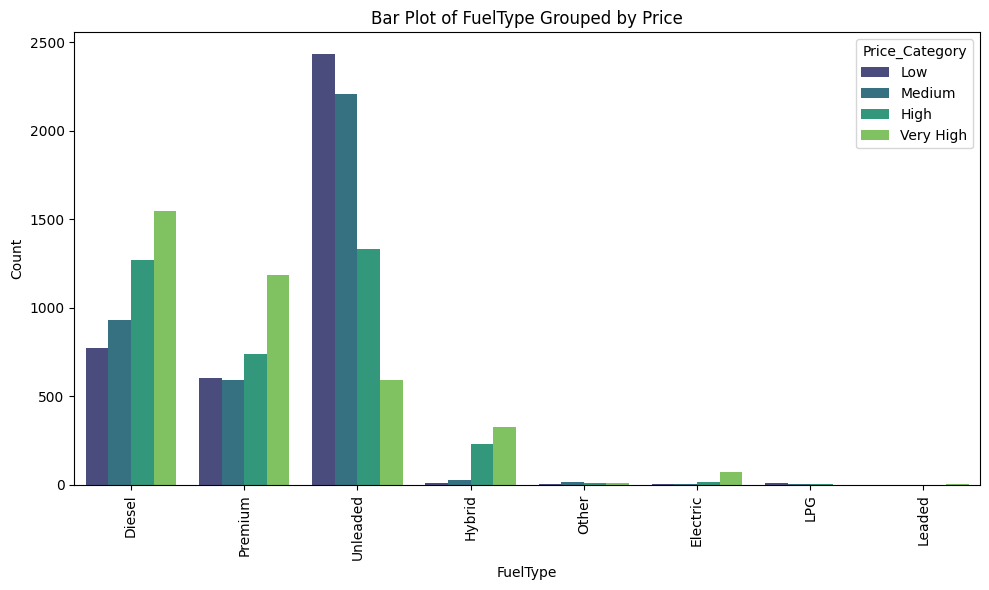

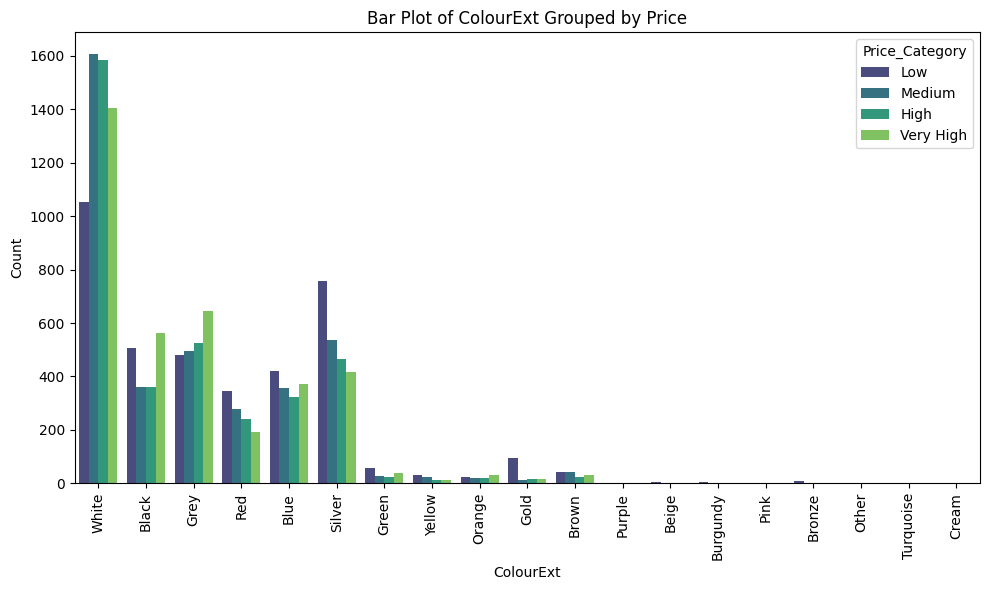

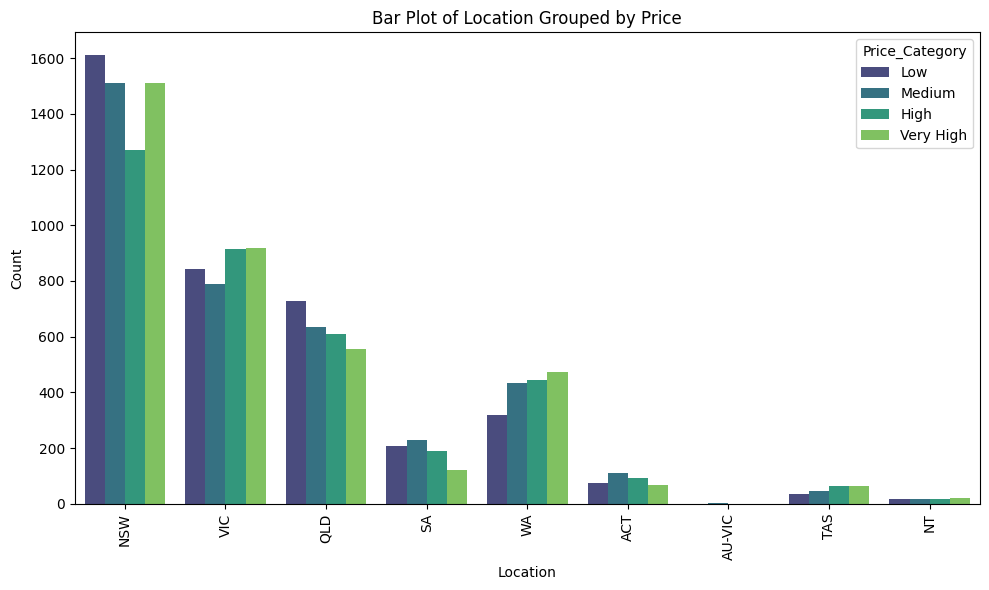

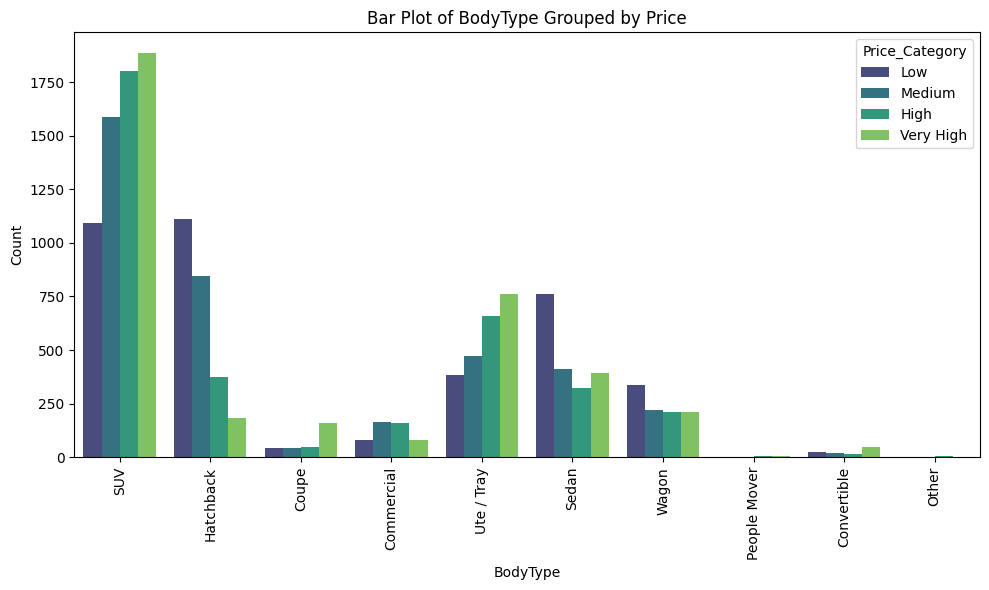

In [14]:
# Creating bins for Price and add a new column 'Price_Category'
price_bins = pd.qcut(df['Price'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])  # Quartiles of Price
df['Price_Category'] = price_bins

# Plotting bar plots for each categorical column grouped by binned 'Price'
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, data=df, hue='Price_Category', palette='viridis')
    plt.title(f'Bar Plot of {col} Grouped by Price')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# Dropping column 'Price_Category'
df.drop(['Price_Category'],axis=1,inplace=True)

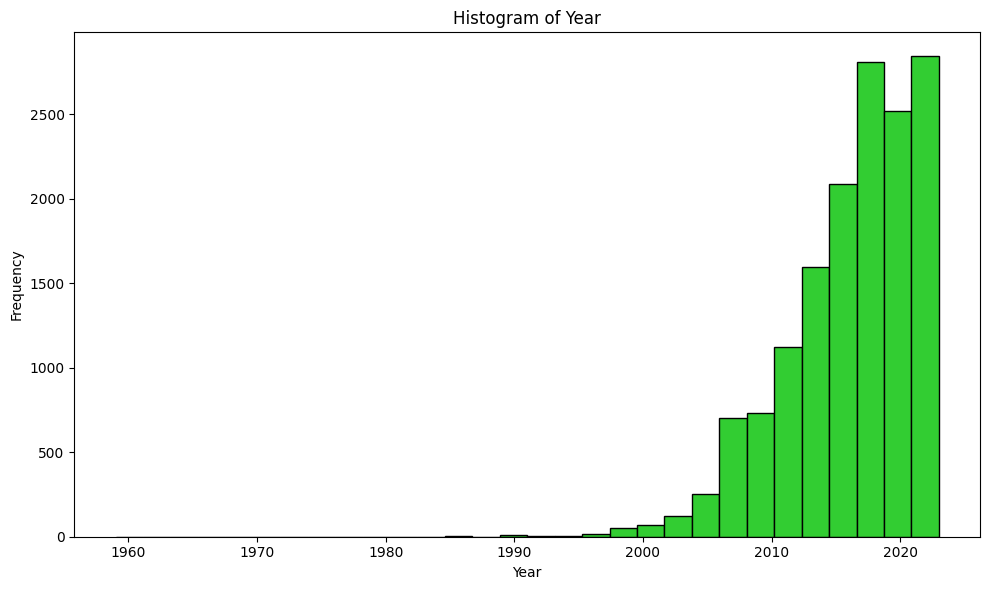

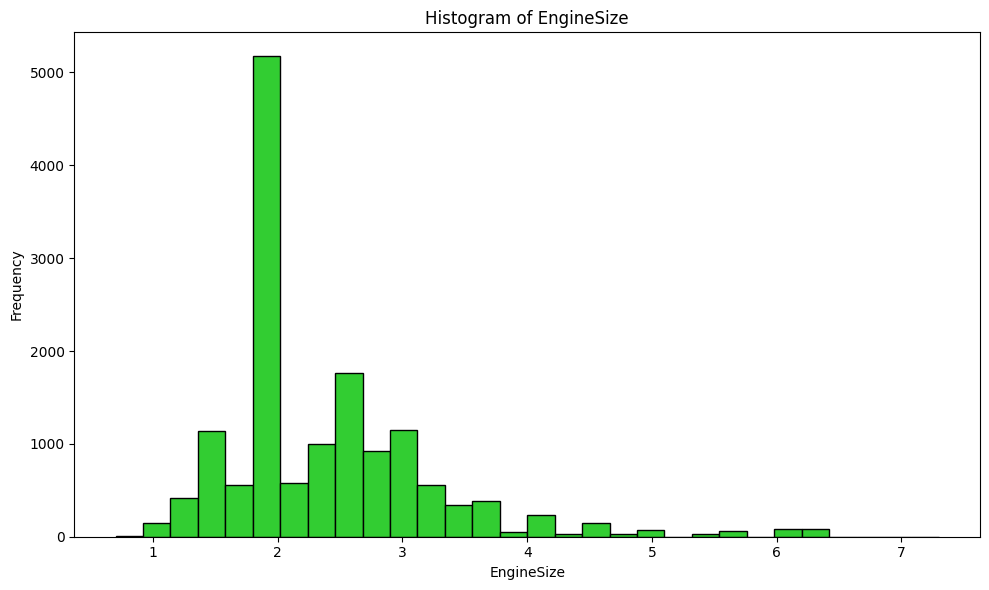

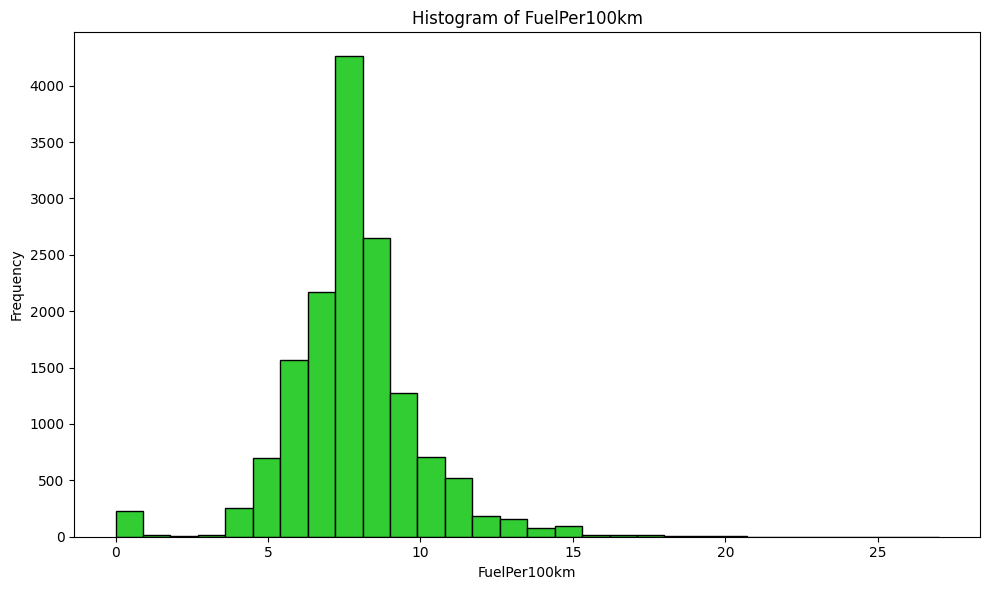

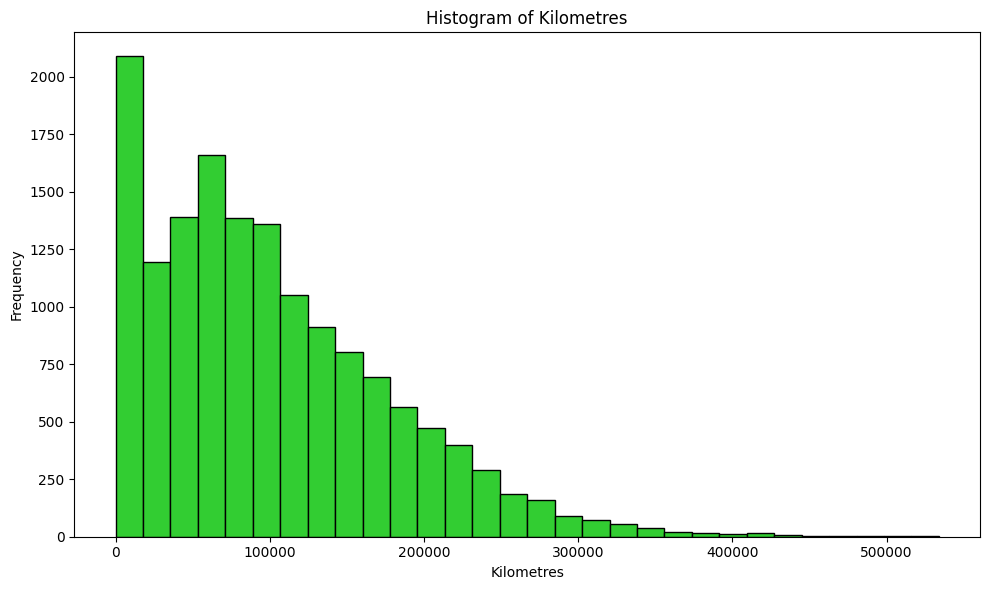

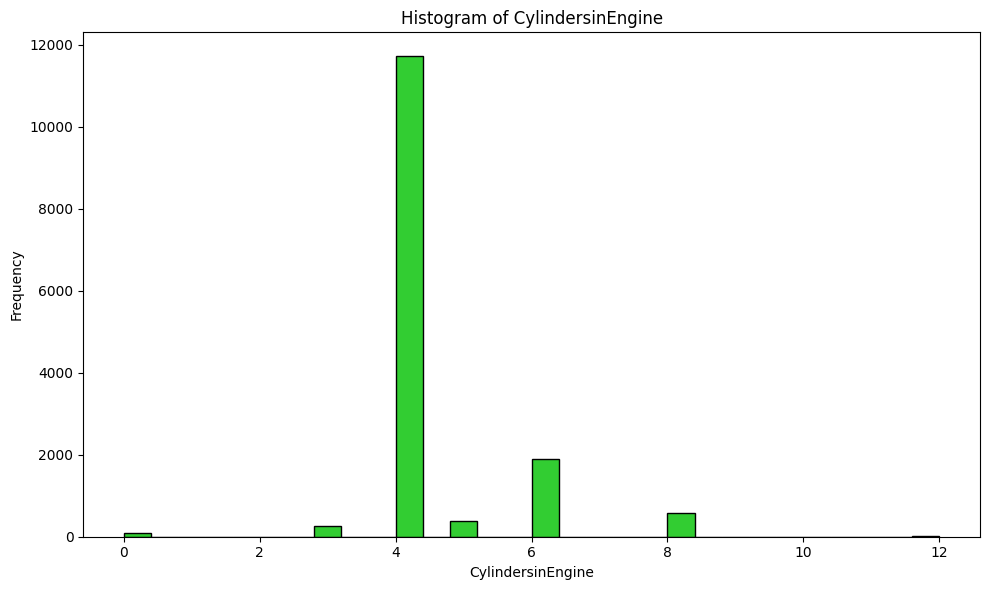

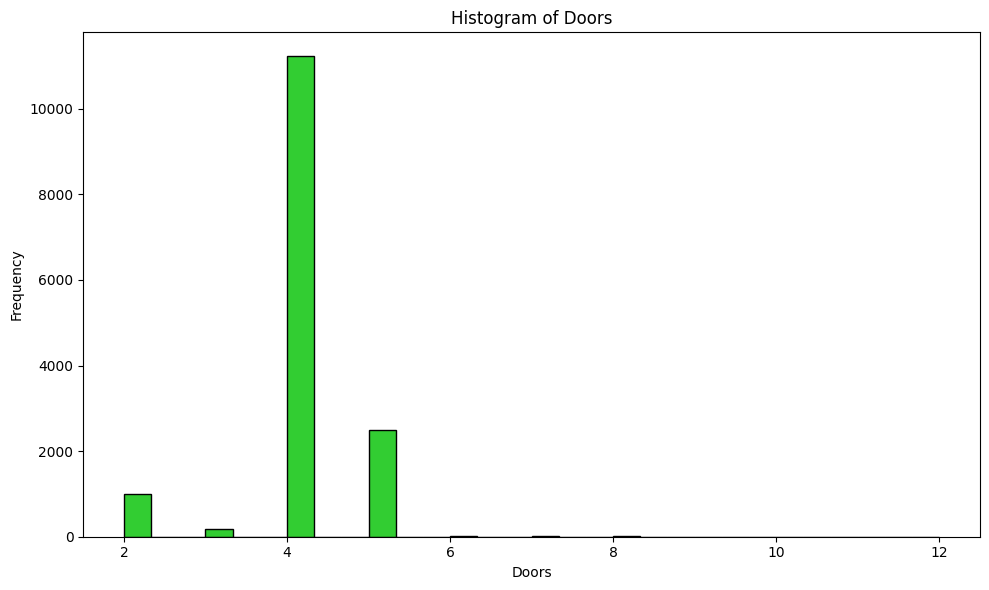

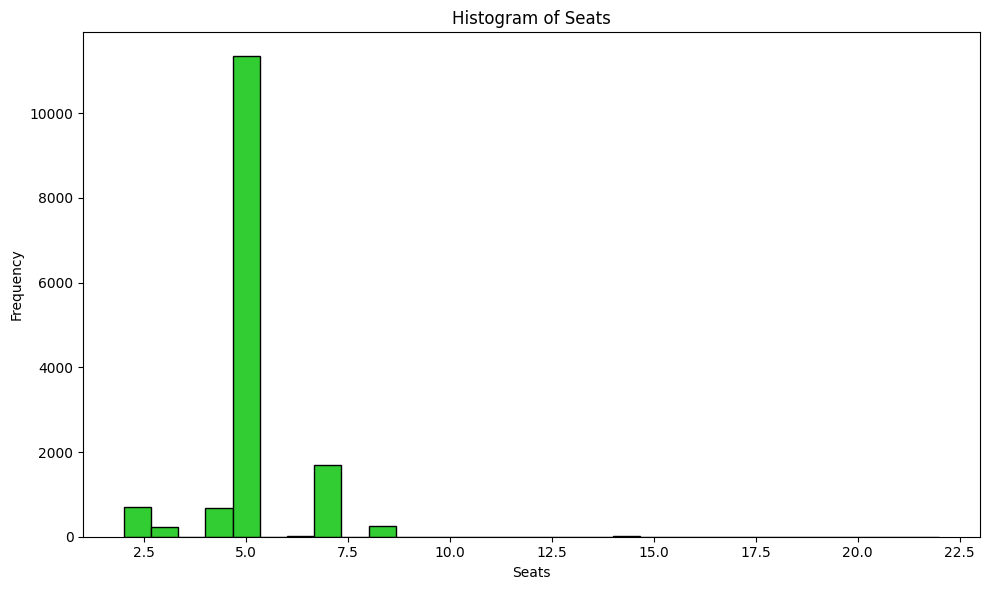

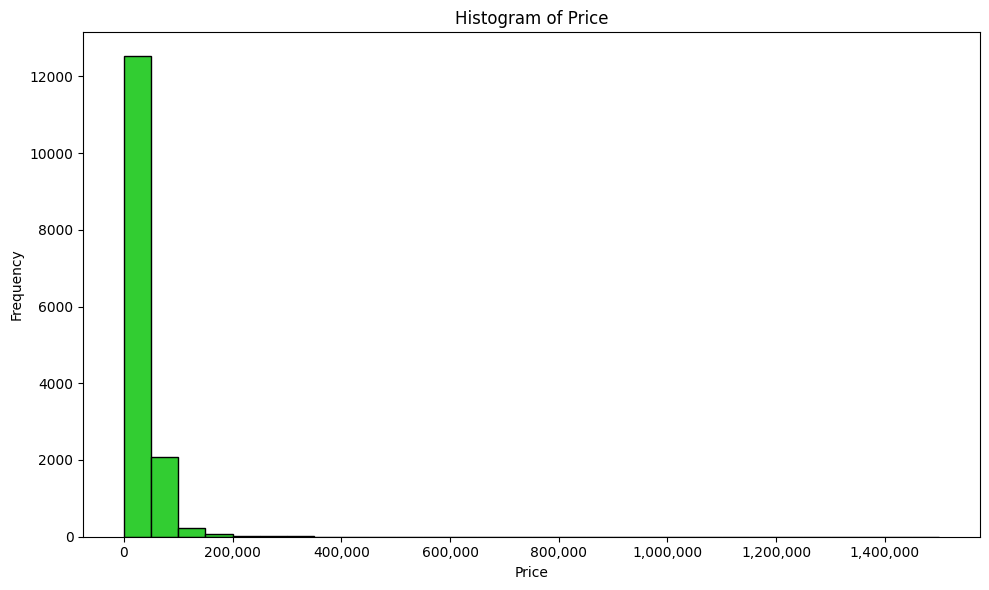

In [15]:
# Identifying numeric columns
numeric_cols = df.select_dtypes(include=['int', 'float']).columns

# Plotting histograms for each numeric column
for col in numeric_cols:
    plt.figure(figsize=(10, 6))
    df[col].hist(bins=30, color='limegreen', edgecolor='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    # Applying custom number formatting for 'Price' to display full numbers
    if col == 'Price':
        plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
    plt.grid(False)
    plt.tight_layout()
    plt.show()

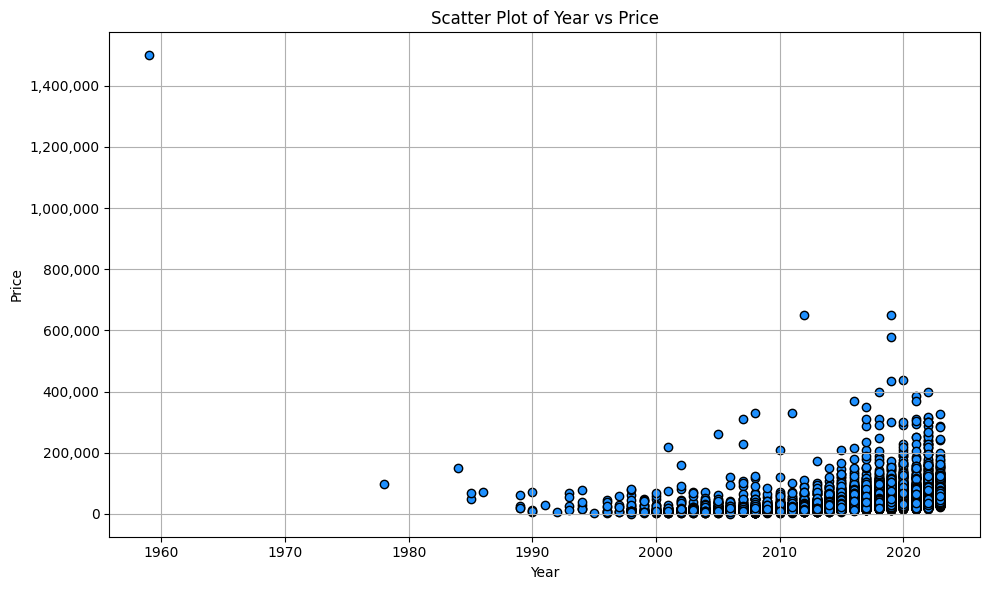

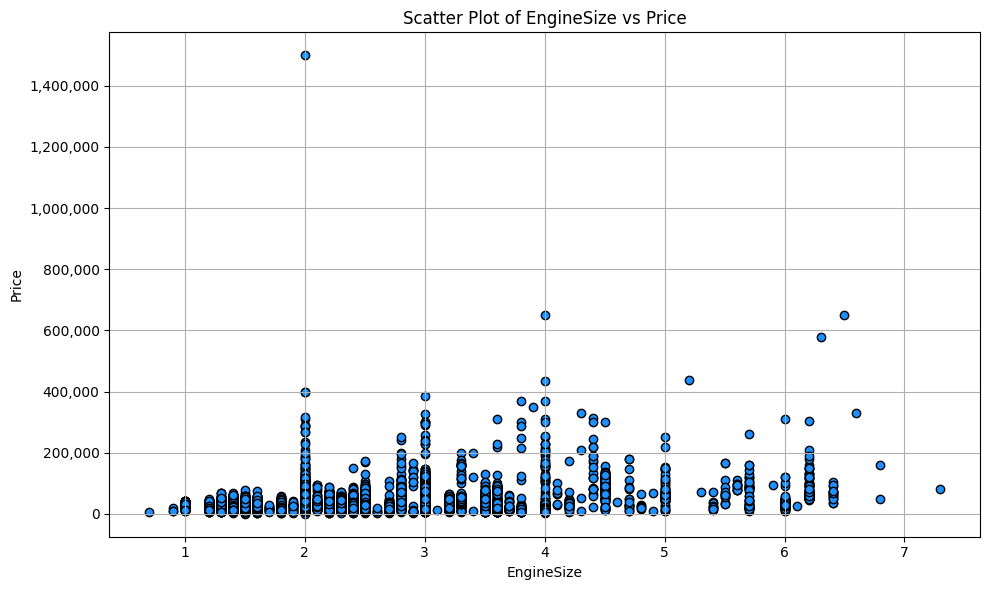

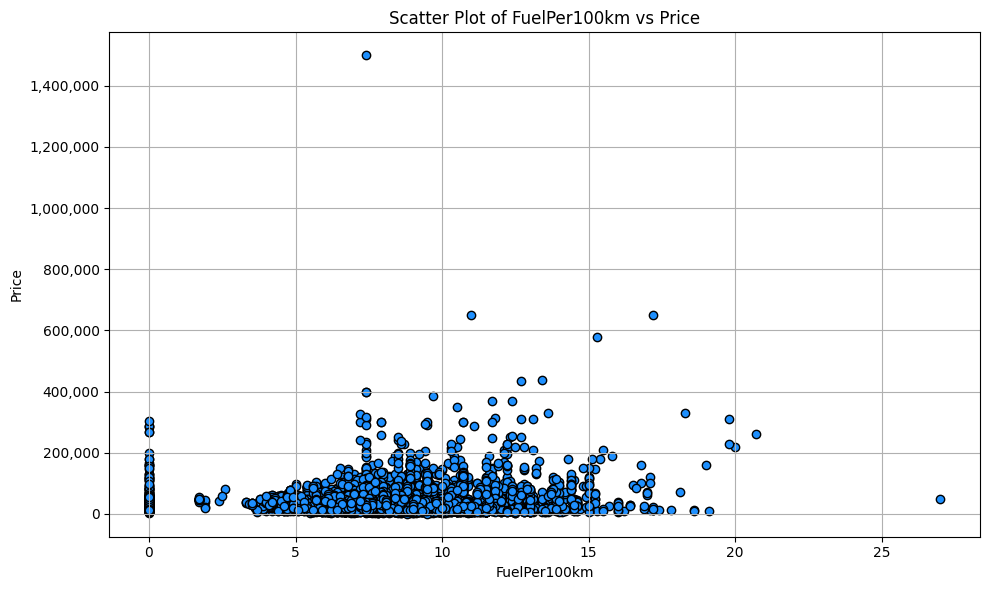

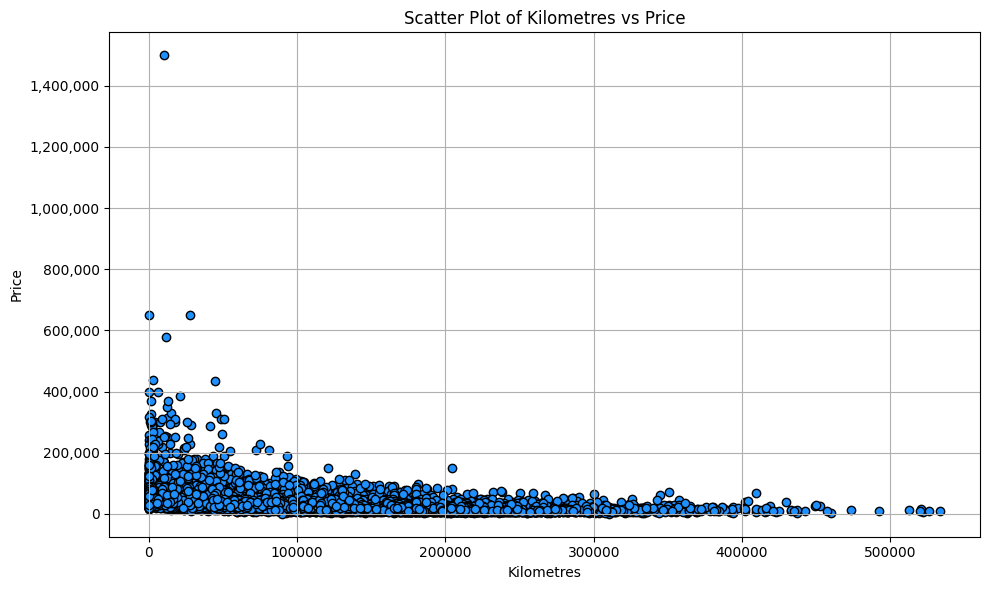

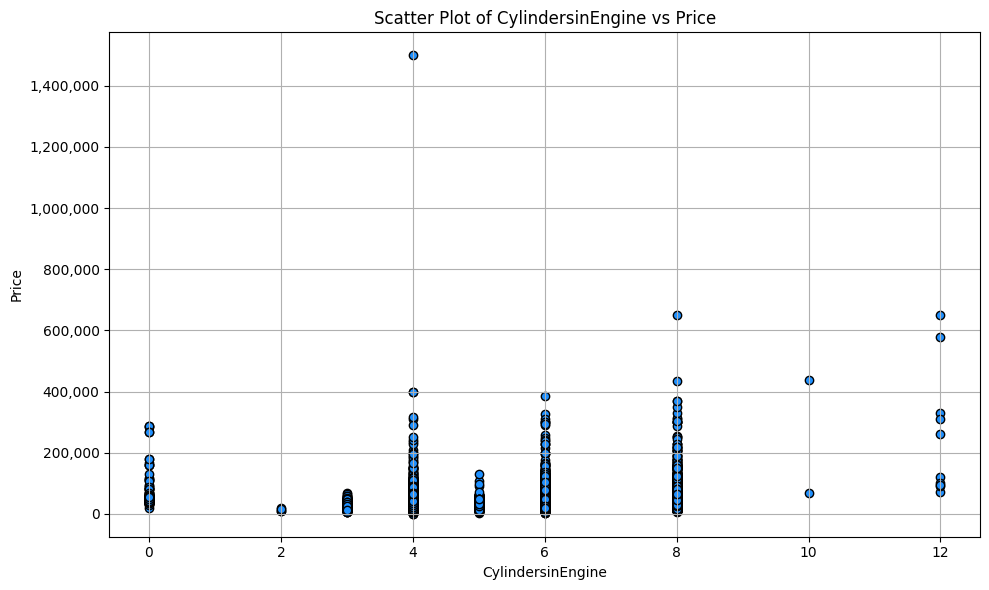

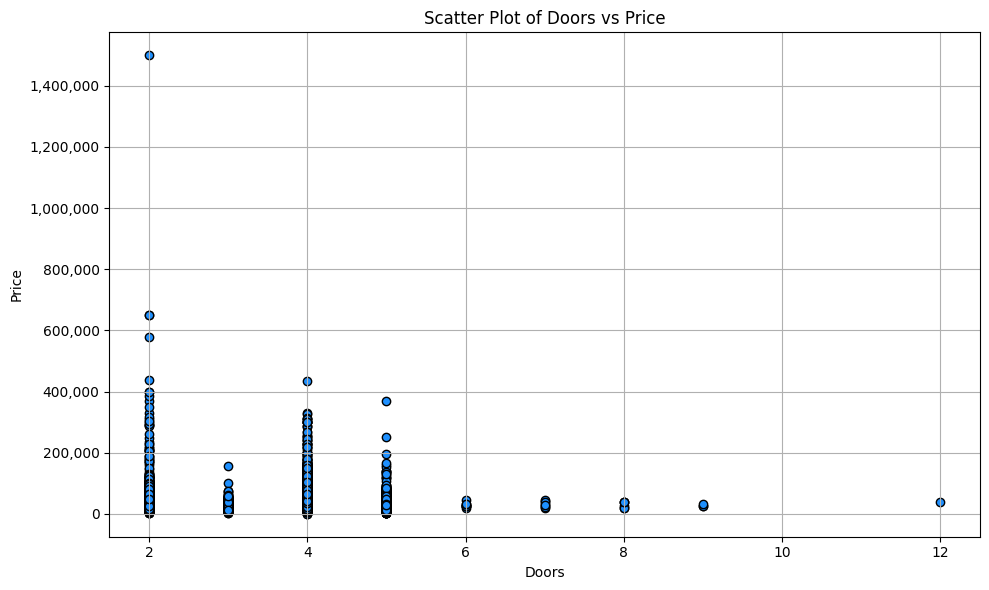

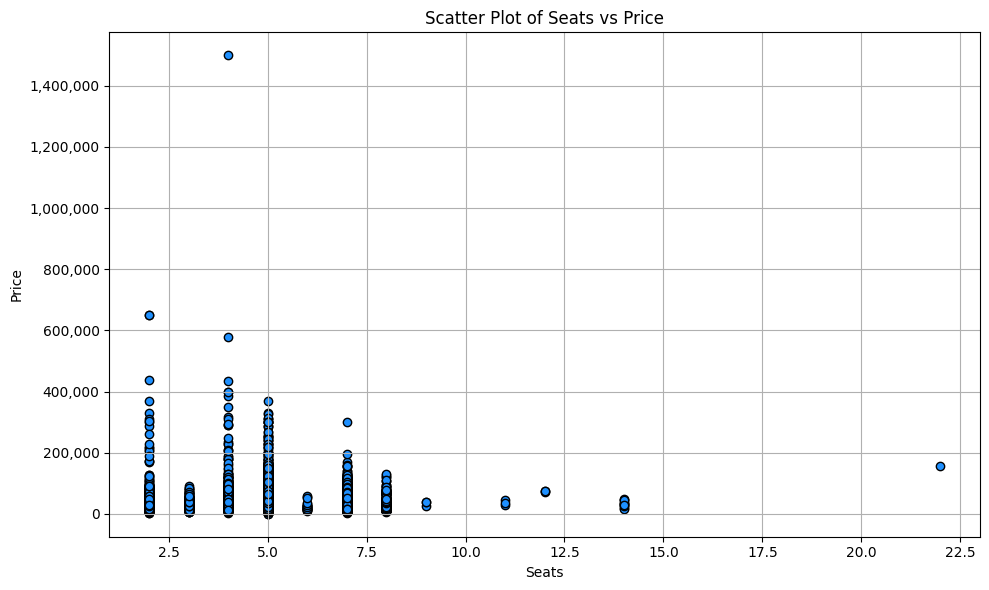

In [16]:
# Dropping 'Price' from numeric column list
numeric_cols = numeric_cols.drop('Price')

# Plotting scatter plots for each numeric column against 'Price'
for col in numeric_cols:
    plt.figure(figsize=(10, 6))
    plt.scatter(df[col], df['Price'], color='dodgerblue', edgecolor='black')
    # Formatting the y-axis to display full numbers instead of scientific notation
    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
    plt.title(f'Scatter Plot of {col} vs Price')
    plt.xlabel(col)
    plt.ylabel('Price')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

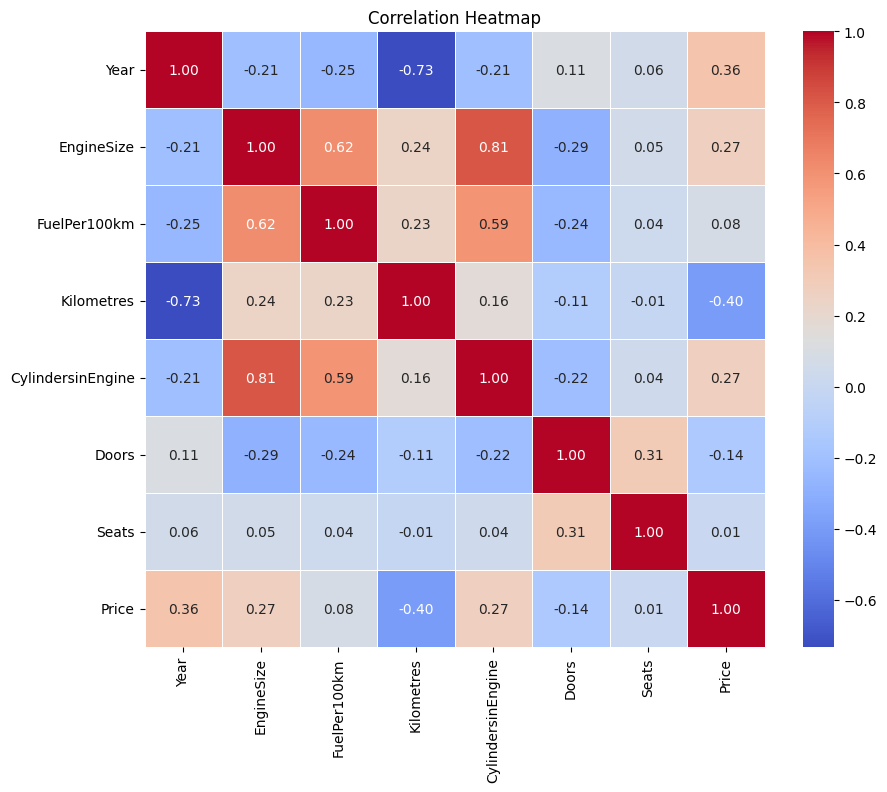

In [17]:
# Identifying numeric columns
numeric_cols = df.select_dtypes(include=['int', 'float']).columns

# Calculating the correlation matrix
corr_matrix = df[numeric_cols].corr()

# Creating a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

#### Outliers

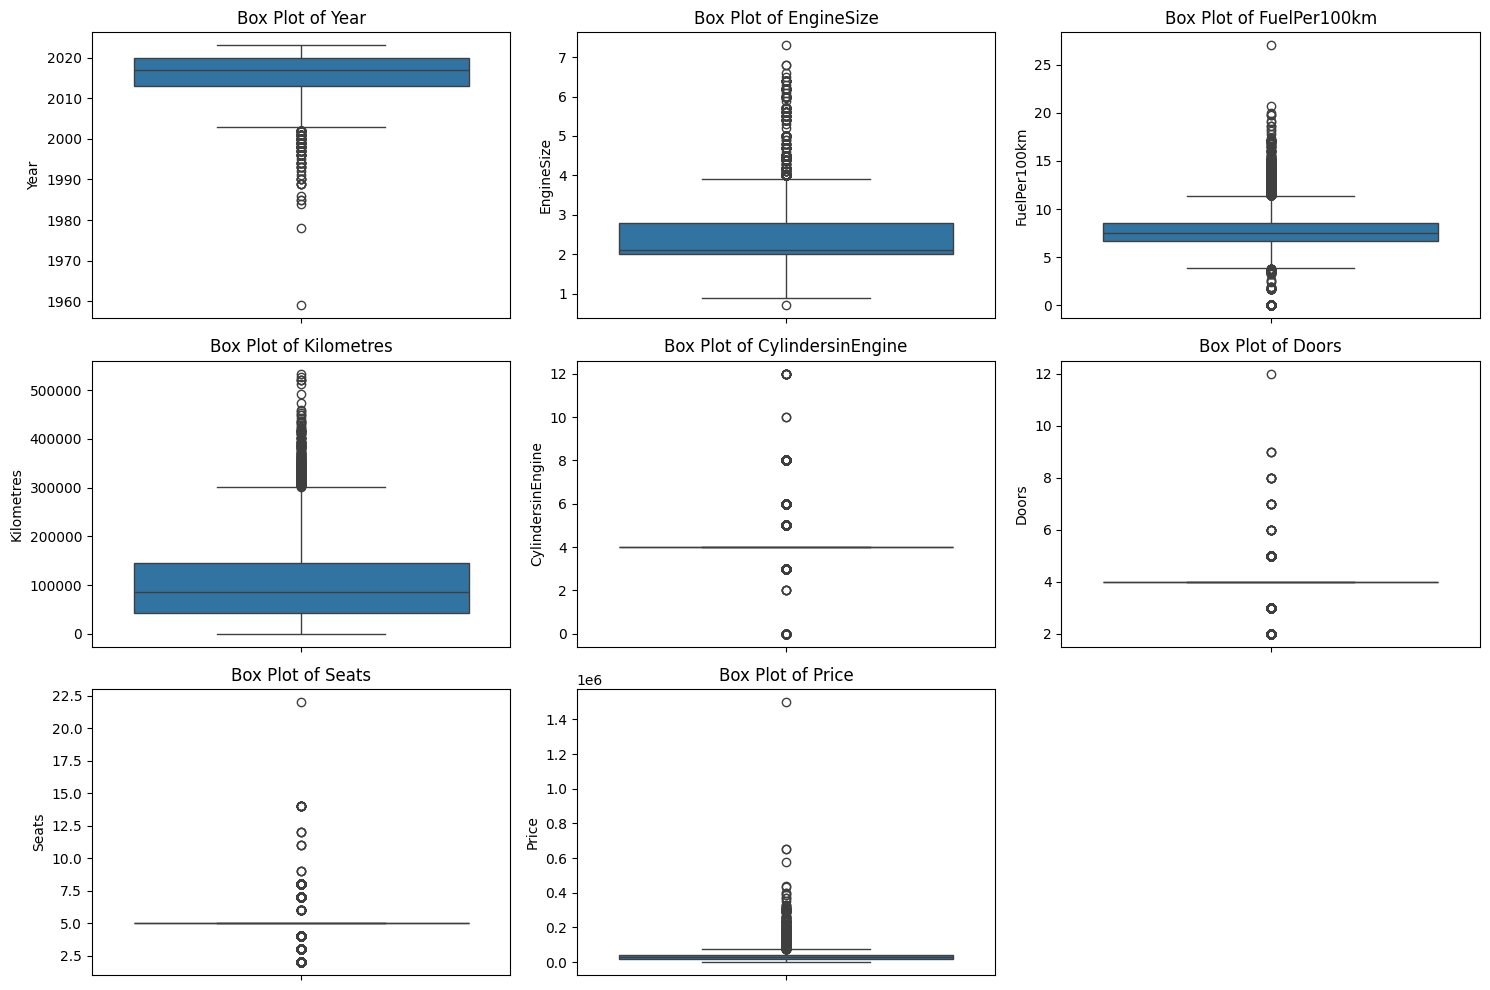

In [18]:
# Creating box plots for each numeric column
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)  
    sns.boxplot(df[col])
    plt.title(f'Box Plot of {col}')
    plt.tight_layout()

plt.show()

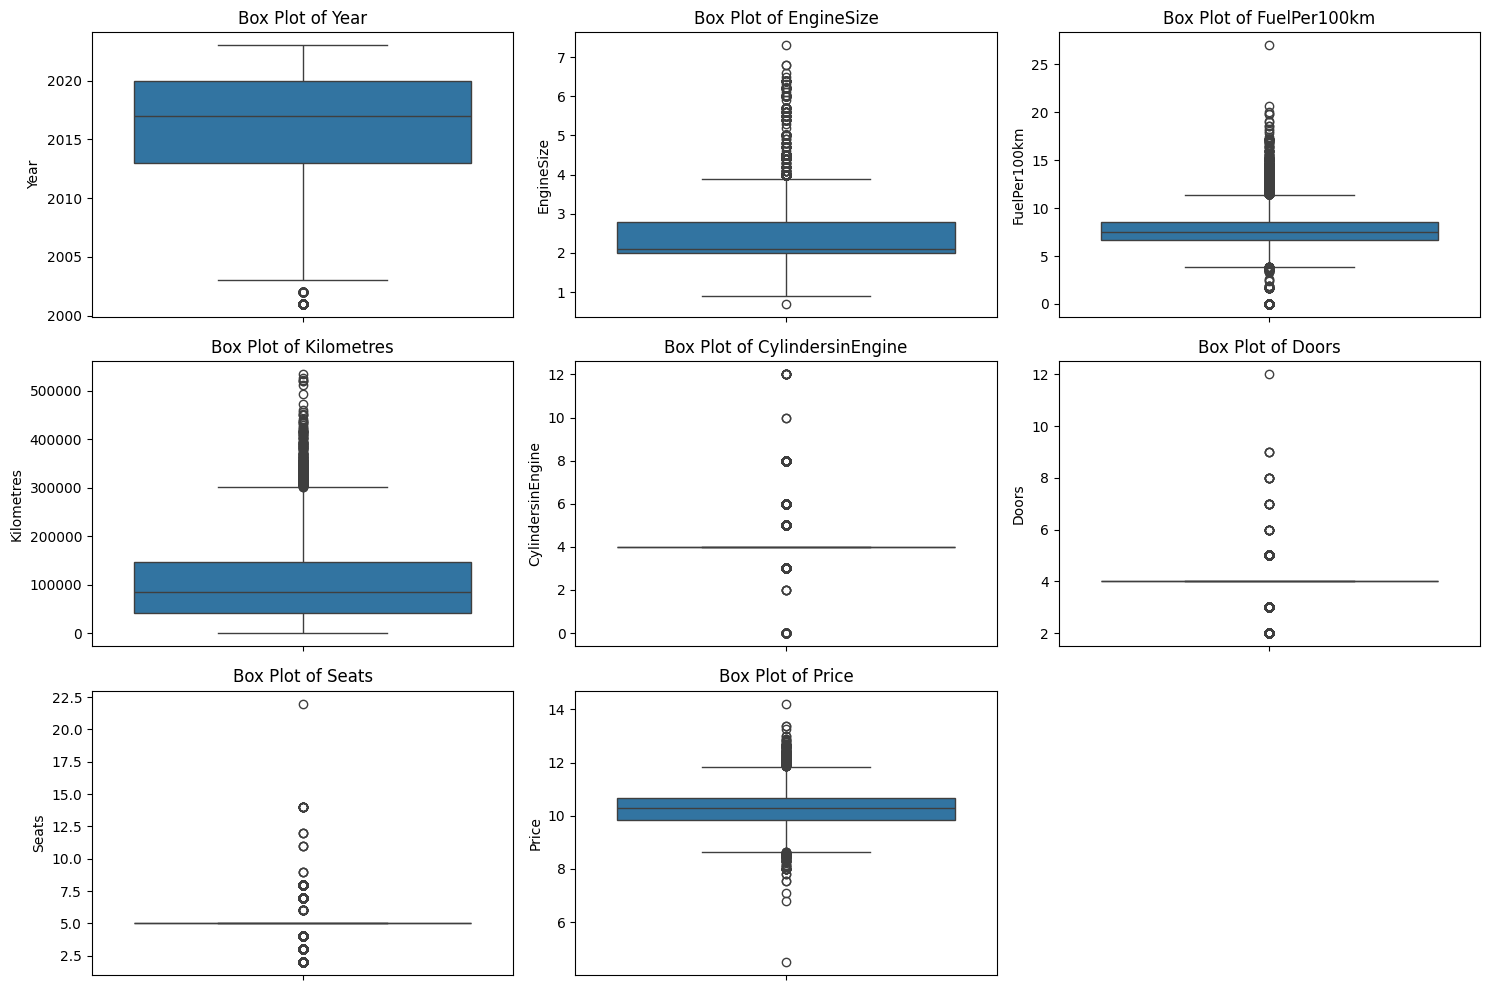

In [19]:
# Capping values in 'Year' to 99th percentile
upper_limit = df['Year'].quantile(0.99)
lower_limit = df['Year'].quantile(0.01)
df['Year'] = np.where(df['Year'] > upper_limit, upper_limit, df['Year'])
df['Year'] = np.where(df['Year'] < lower_limit, lower_limit, df['Year'])

# Converting data with large variance to log value to better fit the model
df['Price'] = np.log(df['Price'] + 1)

# Creating box plots for each numeric column
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)  
    sns.boxplot(df[col])
    plt.title(f'Box Plot of {col}')
    plt.tight_layout()

plt.show()

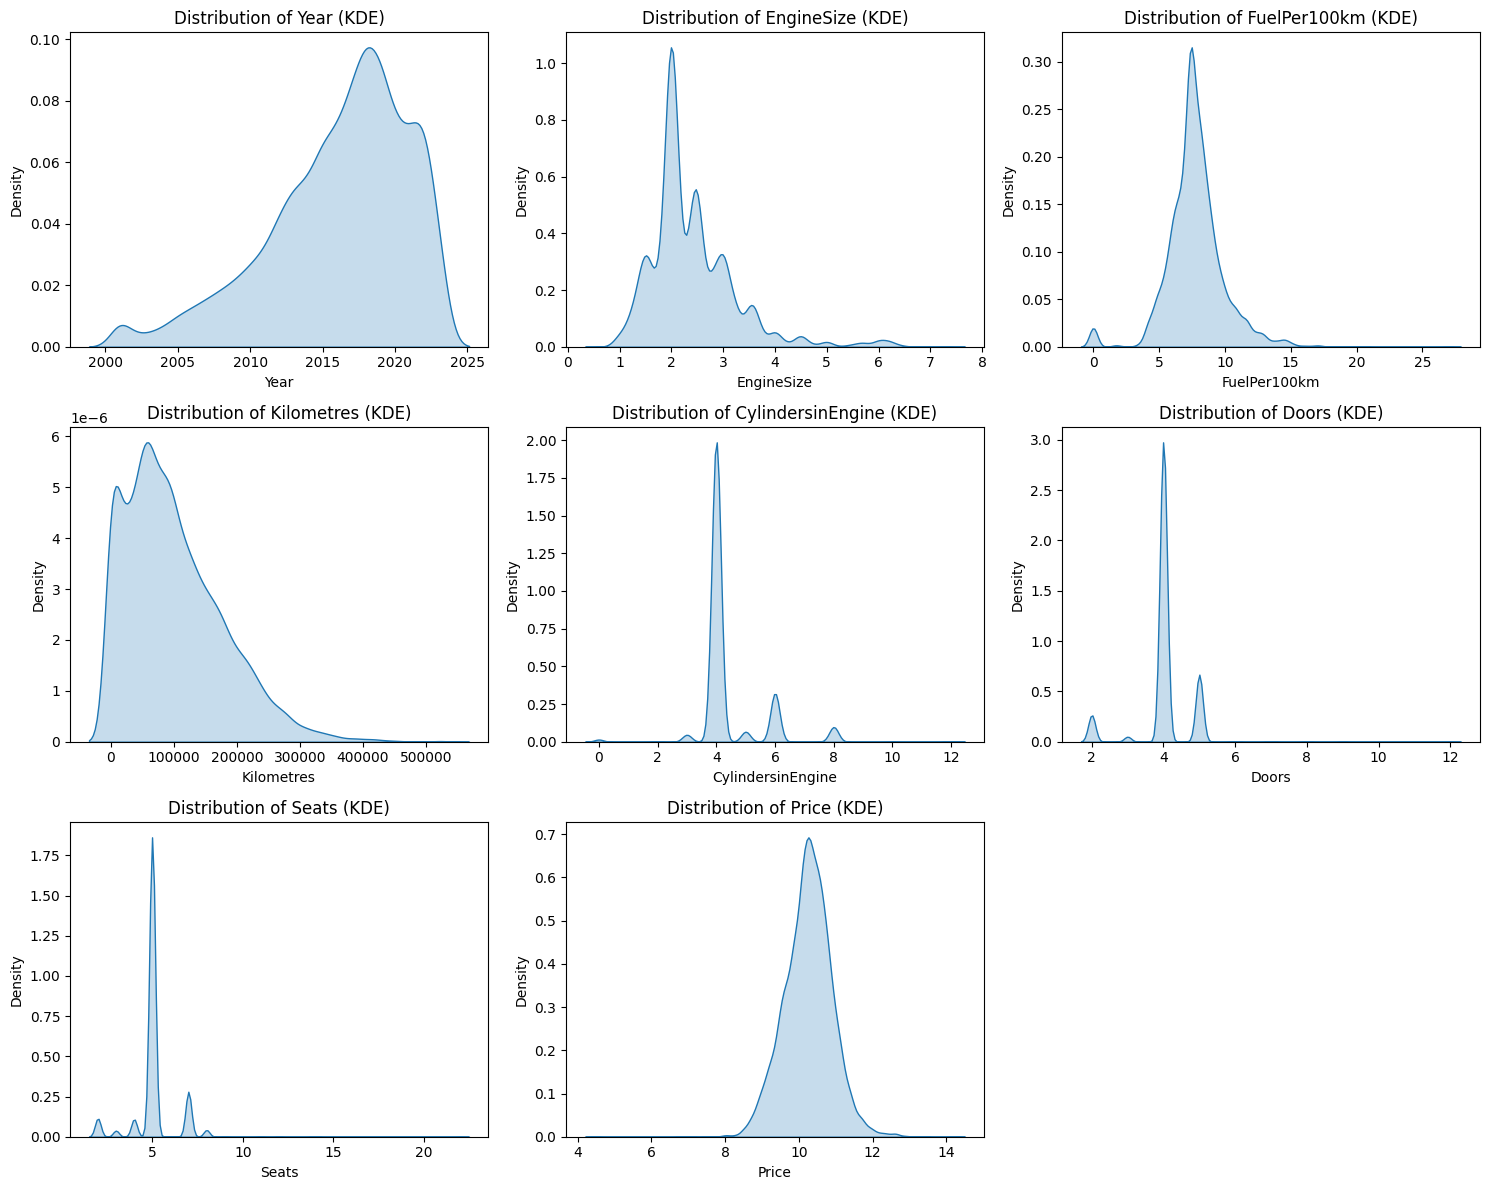

In [20]:
# Creating a 3-row, 3-column grid of subplots for 8 plots
fig, axes = plt.subplots(3, 3, figsize=(15, 12)) 
axes = axes.flatten()  

# Plotting KDE for visualizing data distribution
for i, col in enumerate(numeric_cols[:8]):
    sns.kdeplot(df[col], ax=axes[i], fill=True)
    axes[i].set_title(f'Distribution of {col} (KDE)')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')

# Removing any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Feature Engineering

In [21]:
# Getting the current year from the system
current_year = datetime.datetime.now().year

# Calculating the vehicle age based on the current year
df['VehicleAge'] = current_year - df['Year']

#### Encoding

In [59]:
# Displaying the number of unique categories in each categorical column
unique_categories = df[categorical_cols].nunique()

print(unique_categories)

Brand           66
UsedOrNew        3
Transmission     2
DriveType        5
FuelType         8
ColourExt       19
Location         9
BodyType        10
dtype: int64


In [60]:
# Since too many categories and nominal data in 'Brand', frequency encoding is used
freq = df['Brand'].value_counts()
df['Brand'] = df['Brand'].map(freq)

# Encoding 'Transmission' column 
df['Transmission'] = df['Transmission'].map({'Automatic': 0, 'Manual': 1})

# Using one-hot encoding for the rest
df_encoded = pd.get_dummies(df, columns=['UsedOrNew', 'DriveType', 'FuelType', 'ColourExt', 'Location', 'BodyType'], drop_first=True).astype(int)

# Checking the encoded dataframe
print(df_encoded.head())

   Brand  Year  Transmission  EngineSize  FuelPer100km  Kilometres  \
0     52  2022             0           2             8        5595   
1    212  2022             0           1             6          16   
2    415  2022             0           2             6        8472   
3    557  2011             0           5            11      136517   
4    146  2022             0           1             6        1035   

   CylindersinEngine  Doors  Seats  Price  VehicleAge  UsedOrNew_NEW  \
0                  4      4      7     10           2              0   
1                  4      5      5      9           2              0   
2                  4      2      4     11           2              0   
3                  8      2      4     10          13              0   
4                  4      4      5     10           2              0   

   UsedOrNew_USED  DriveType_AWD  DriveType_Front  DriveType_Other  \
0               0              1                0                0   
1     

#### Feature Scaling

In [61]:
# Columns to standardize
columns_to_standardize = ['Year', 'EngineSize', 'FuelPer100km', 'Kilometres', 'CylindersinEngine', 'Doors',
                          'Seats', 'VehicleAge']

# Initializing the StandardScaler
scale = StandardScaler()

# Fitting and transforming the data
df_encoded[columns_to_standardize] = scale.fit_transform(df_encoded[columns_to_standardize])

#### Data Preparation for ML Models

In [62]:
# Separating features (X) and target (y)
X = df_encoded.drop("Price", axis=1)
y = df_encoded["Price"]

# Splitting data into training and testing sets with 70-30 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Calculating the number of samples (n) and features (p)
n = len(y_test)  # Number of samples in the test set
p = X_test.shape[1]  # Number of features (predictors)

#### Machine Learning(ML) Model Training

##### Logistic Regression Model

In [63]:
# Initializing the LogisticRegression model
lr = LogisticRegression()

# Fitting the model and predicting 
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Storing matrices for evaluation
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mape_lr = mean_absolute_percentage_error(y_test, y_pred_lr) * 100
r2_lr = r2_score(y_test, y_pred_lr)
adj_r2_lr = 1 - (1 - r2_lr) * (n - 1) / (n - p - 1)

##### Decision Tree Model

In [170]:
# Initializing the DecisionTreeRegressor model
dt = DecisionTreeRegressor()

# Defining the parameter grid for GridSearchCV
param_grid_dt = {
    'criterion': ['mse', 'friedman_mse', 'mae'],  # Splitting criteria
    'max_depth': [None, 10, 20],               # Maximum depth of the tree
    'min_samples_split': [5, 10, 20],          # Minimum samples required to split an internal node
    'min_samples_leaf': [2, 4, 8],             # Minimum samples required to be at a leaf node
}

# Performing GridSearchCV for hyperparameter tuning
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='r2', n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

# Getting the best parameters
print("Best parameters found: ", grid_search_dt.best_params_)

Best parameters found:  {'criterion': 'friedman_mse', 'max_depth': 20, 'min_samples_leaf': 8, 'min_samples_split': 20}


In [64]:
# Modelling with the the best features
dt = DecisionTreeRegressor(criterion='friedman_mse', max_depth=20, min_samples_leaf=8, min_samples_split=20)

# Fitting the model and predicting 
dt.fit(X_train,y_train)
y_pred_dt = dt.predict(X_test)

# Storing matrices for evaluation
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
mape_dt = mean_absolute_percentage_error(y_test, y_pred_dt) * 100
r2_dt = r2_score(y_test, y_pred_dt)
adj_r2_dt = 1 - (1 - r2_dt) * (n - 1) / (n - p - 1)

##### KNN Model

In [172]:
# Initializing the KNeighborsRegressor model
knn = KNeighborsRegressor()

# Parameter grid for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Performing GridSearchCV
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='r2')
grid_search_knn.fit(X_train, y_train)

# Getting the best parameters
print("Best parameters found: ", grid_search_knn.best_params_)

Best parameters found:  {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}


In [65]:
# Modelling with the the best features
knn = KNeighborsRegressor(metric='manhattan', n_neighbors=9, weights='distance')

# Fitting the model and predicting 
knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_test)

# Storing matrices for evaluation
mse_knn = mean_squared_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
mape_knn = mean_absolute_percentage_error(y_test, y_pred_knn) * 100
r2_knn = r2_score(y_test, y_pred_knn)
adj_r2_knn = 1 - (1 - r2_knn) * (n - 1) / (n - p - 1)

##### Random Forest Model

In [174]:
# Initializing the RandomForestRegressor model
rf = RandomForestRegressor()

# Parameter grid for random forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
}

# Performing GridSearchCV
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='r2')
grid_search_rf.fit(X_train, y_train)

# Getting the best parameters
print("Best parameters found: ", grid_search_rf.best_params_)

Best parameters found:  {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [66]:
# Modelling with the the best features
rf = RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=200)

# Fitting the model and predicting 
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)

# Storing matrices for evaluation
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf) * 100
r2_rf = r2_score(y_test, y_pred_rf)
adj_r2_rf = 1 - (1 - r2_rf) * (n - 1) / (n - p - 1)

##### Gradient Boost Model

In [176]:
# Initializing the GradientBoostingRegressor model
gb = GradientBoostingRegressor()

# Defining the parameter grid for GridSearchCV
param_grid_gb = {
    'n_estimators': [50, 100, 200],            # Number of boosting stages
    'learning_rate': [0.01, 0.1, 0.2, 0.3],    # Step size shrinkage
    'max_depth': [3, 5, 7, 10],                # Maximum depth of the individual trees
    'min_samples_split': [2, 5, 10],           # Minimum number of samples to split an internal node
    'min_samples_leaf': [1, 2, 4],             # Minimum number of samples to be at a leaf node
    'subsample': [0.6, 0.8, 1.0],              # Fraction of samples used for fitting the individual trees
    'max_features': ['auto', 'sqrt', 'log2']    # Number of features to consider when looking for the best split
}

# Performing GridSearchCV for hyperparameter tuning
grid_search_gb = GridSearchCV(gb, param_grid_gb, cv=5, scoring='r2', n_jobs=-1)
grid_search_gb.fit(X_train, y_train)

# Getting the best parameters
print("Best parameters found: ", grid_search_gb.best_params_)

Best parameters found:  {'learning_rate': 0.1, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 1.0}


In [67]:
# modelling with the the best features
gb = GradientBoostingRegressor(learning_rate=0.1, max_depth=10, max_features='sqrt', min_samples_leaf=4, min_samples_split=5, 
                               n_estimators=200, subsample=1.0)

# Fitting the model and predicting 
gb.fit(X_train,y_train)
y_pred_gb = gb.predict(X_test)

# Storing matrices for evaluation
mse_gb = mean_squared_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mape_gb = mean_absolute_percentage_error(y_test, y_pred_gb) * 100
r2_gb = r2_score(y_test, y_pred_gb)
adj_r2_gb = 1 - (1 - r2_gb) * (n - 1) / (n - p - 1)

##### XGB Model

In [178]:
# Initializing the XGBRegressor model
xgb = XGBRegressor()

# Parameter grid for XGBRegressor
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0]
}

# Performing GridSearchCV
grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='r2')
grid_search_xgb.fit(X_train, y_train)

# Getting the best parameters
print("Best parameters found: ", grid_search_xgb.best_params_)

Best parameters found:  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


In [68]:
# Modelling with the the best features
xgb = XGBRegressor(learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8)

# Fitting the model and predicting 
xgb.fit(X_train,y_train)
y_pred_xgb = xgb.predict(X_test)

# Storing matrices for evaluation
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb) * 100
r2_xgb = r2_score(y_test, y_pred_xgb)
adj_r2_xgb = 1 - (1 - r2_xgb) * (n - 1) / (n - p - 1)

#### ML Model Evaluation

In [69]:
metrics = {
    'Model': ['Linear Regression', 'Decision Tree', 'K-Nearest Neighbour', 'Random Forest', 'Gradient Boosting', 'XG Boost'],
    'R-Squared': [r2_lr, r2_dt, r2_knn, r2_rf, r2_gb, r2_xgb],
    'Adjusted R-Squared': [adj_r2_lr, adj_r2_dt, adj_r2_knn, adj_r2_rf, adj_r2_gb, adj_r2_xgb],
    'MAE': [mae_lr, mae_dt, mae_knn, mae_rf, mae_gb, mae_xgb],
    'MSE': [mse_lr, mse_dt, mse_knn, mse_rf, mse_gb, mse_xgb],
    'RMSE': [rmse_lr, rmse_dt, rmse_knn, rmse_rf, rmse_gb, rmse_xgb],
    'MAPE (%)': [mape_lr, mape_dt, mape_knn, mape_rf, mape_gb, mape_xgb]
}

# Create a DataFrame to display the table
metrics_df = pd.DataFrame(metrics)

# Display the table
print(metrics_df)

                 Model  R-Squared  Adjusted R-Squared       MAE       MSE  \
0    Linear Regression   0.415167            0.407500  0.272139  0.299799   
1        Decision Tree   0.690936            0.686884  0.234083  0.158433   
2  K-Nearest Neighbour   0.744296            0.740944  0.227685  0.131080   
3        Random Forest   0.765965            0.762896  0.222635  0.119972   
4    Gradient Boosting   0.780560            0.777683  0.232612  0.112490   
5             XG Boost   0.784842            0.782021  0.227966  0.110295   

       RMSE  MAPE (%)  
0  0.547539  2.792335  
1  0.398037  2.435532  
2  0.362050  2.388365  
3  0.346370  2.313569  
4  0.335395  2.413854  
5  0.332107  2.363497  


####  Deep Learning(DL) Model Training

##### Data Preparation for DL Models

In [70]:
# Converting to NumPy arrays
X1 = X.to_numpy()
y1 = y.to_numpy()

# Splitting the data into training and testing sets (70% train, 30% test)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=0)

# Reshaping the data for GRU, LSTM, RNN (requires 3D input: [samples, timesteps, features])
X2 = X1.reshape((X1.shape[0], 1, X1.shape[1]))

# Splitting the data into training and testing sets with modified X (70% train, 30% test)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y1, test_size=0.3, random_state=0)

##### GRU Model

In [71]:
# Initializing the Sequential model
gru_model = Sequential()

# GRU layer with 50 units
gru_model.add(GRU(50, input_shape=(1, 58)))

# Output layer for regression
gru_model.add(Dense(1))  # Linear output layer since this is regressio

# Compiling the model with 'mean_squared_error' as loss for regression
gru_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error', 'mean_absolute_error'])

# Training the model on the train data
gru_model.fit(X2_train, y2_train, batch_size=10, epochs=100, verbose=0)

# Making predictions on the test data
y_pred_gru = gru_model.predict(X2_test)

# Evaluate the model on the test data
loss_gru, mse_gru, mae_gru = gru_model.evaluate(X2_test, y2_test, verbose=0)

# Calculating R-squared on the test set
r2_gru = r2_score(y2_test, y_pred_gru)

141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


##### MLP Model

In [72]:
# Initializing the Sequential model
mlp_model = Sequential()

# Input layer with 58 features and first hidden layer with 50 neurons, using 'relu' activation
mlp_model.add(Dense(50, input_dim=58, activation='relu'))

# Second hidden layer with 4 neurons
mlp_model.add(Dense(4, activation='relu'))

# Output layer for regression, no activation function (linear output)
mlp_model.add(Dense(1))

# Compiling the model with 'mean_squared_error' as loss for regression
mlp_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error', 'mean_absolute_error'])

# Training the model on the train data
mlp_model.fit(X1_train, y1_train, batch_size=10, epochs=100, verbose=0)

# Making predictions on the test data
y_pred_mlp = mlp_model.predict(X1_test)

# Evaluate the model on the test data
loss_mlp, mse_mlp, mae_mlp = mlp_model.evaluate(X1_test, y1_test, verbose=0)

# Calculating R-squared on the test set
r2_mlp = r2_score(y1_test, y_pred_mlp)

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


##### LSTM Model

In [73]:
# Initializing the Sequential model for LSTM
lstm_model = Sequential()

# LSTM layer with 50 units (neurons), input_shape is [timesteps, features]
lstm_model.add(LSTM(50, input_shape=(1, 58)))

# Output layer for regression
lstm_model.add(Dense(1))

# Compiling the model with 'mean_squared_error' as loss for regression
lstm_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error', 'mean_absolute_error'])

# Training the model
lstm_model.fit(X2_train, y2_train, batch_size=10, epochs=100, verbose=0)

# Making predictions on the test set
y_pred_lstm = lstm_model.predict(X2_test)

# Evaluating the model
loss_lstm, mse_lstm, mae_lstm = lstm_model.evaluate(X2_test, y2_test, verbose=0)

# Calculate R-squared for the test set
r2_lstm = r2_score(y2_test, y_pred_lstm)

141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


##### RNN Model

In [74]:
# Initializing the Sequential model for RNN
rnn_model = Sequential()

# SimpleRNN layer with 50 units (neurons), input_shape is [timesteps, features]
rnn_model.add(SimpleRNN(50, input_shape=(1, 58)))

# Output layer for regression
rnn_model.add(Dense(1))

# Compiling the model with 'mean_squared_error' as loss for regression
rnn_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error', 'mean_absolute_error'])

# Training the model
rnn_model.fit(X2_train, y2_train, batch_size=10, epochs=100, verbose=0)

# Making predictions on the test set
y_pred_rnn = rnn_model.predict(X2_test)

# Evaluating the model 
loss_rnn, mse_rnn, mae_rnn = rnn_model.evaluate(X2_test, y2_test, verbose=0)

# Calculating R-squared for the test set
r2_rnn = r2_score(y2_test, y_pred_rnn)

141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


#### DL Model Evaluation

In [75]:
metrices = {
    'Model': ['GRU', 'MLP', 'LSTM', 'RNN'],
    'R-Squared': [r2_gru, r2_mlp, r2_lstm, r2_rnn],
    'Loss' : [loss_gru, loss_mlp, loss_lstm, loss_rnn],
    'MSE': [mse_gru, mse_mlp, mse_lstm, mse_rnn],
    'MAE': [mae_gru, mae_mlp, mae_lstm, mae_rnn]
}

# Create a DataFrame to display the table
metrices_df = pd.DataFrame(metrices)

# Display the table
print(metrices_df)

  Model  R-Squared      Loss       MSE       MAE
0   GRU   0.428885  0.292767  0.292767  0.393745
1   MLP   0.700295  0.153636  0.153636  0.301039
2  LSTM   0.672261  0.168007  0.168007  0.278027
3   RNN   0.553858  0.228703  0.228703  0.315506


#### Feature Importance

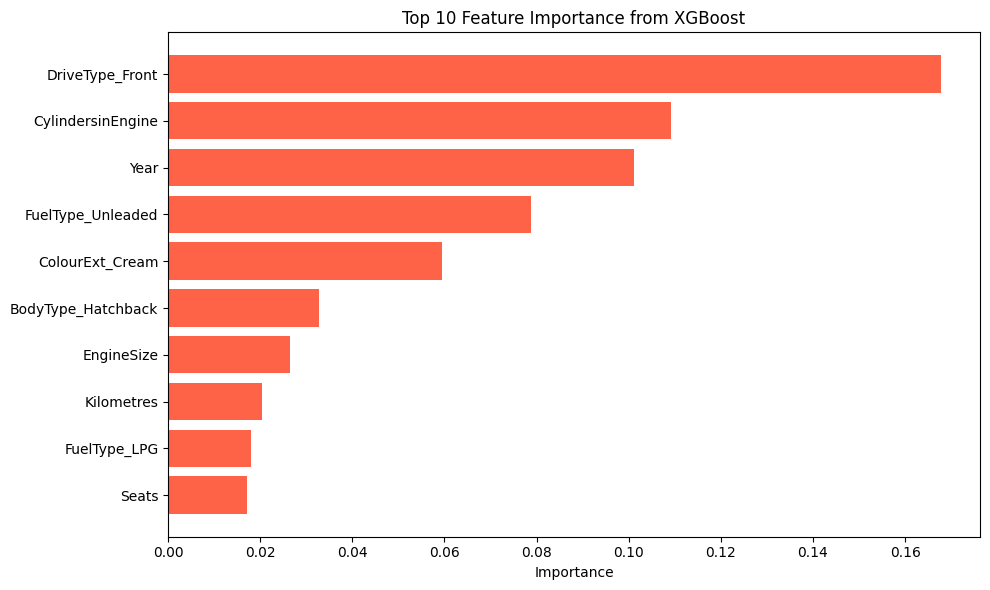

In [76]:
# Separating features (X) and target (y)
X = df_encoded.drop("Price", axis=1)
y = df_encoded["Price"]

# Retrieving and display feature importance
feature_importances = xgb.feature_importances_
features = X.columns

# Creating a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sorting the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Slicing the DataFrame to get the top 10 most important features
top_10_features = importance_df.head(10)

# Plotting the top 10 feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='tomato')
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance from XGBoost')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()

#### Feature Selection

Current MSE: 0.11029501827821651, R2: 0.7848420739173889, Features Remaining: 58
Removed Feature: Location_AU-VIC
Current MSE: 0.11029501827821651, R2: 0.7848420739173889, Features Remaining: 57
Removed Feature: ColourExt_Turquoise
Current MSE: 0.11029501827821651, R2: 0.7848420739173889, Features Remaining: 56
Removed Feature: ColourExt_Burgundy
Current MSE: 0.11029501827821651, R2: 0.7848420739173889, Features Remaining: 55
Removed Feature: ColourExt_Pink
Current MSE: 0.11029501827821651, R2: 0.7848420739173889, Features Remaining: 54
Removed Feature: BodyType_People Mover
Current MSE: 0.11029501827821651, R2: 0.7848420739173889, Features Remaining: 53
Removed Feature: ColourExt_Other
Current MSE: 0.11029501827821651, R2: 0.7848420739173889, Features Remaining: 52
Removed Feature: VehicleAge
Current MSE: 0.11029501827821651, R2: 0.7848420739173889, Features Remaining: 51
Removed Feature: BodyType_Other
Current MSE: 0.10989194938138085, R2: 0.7856283783912659, Features Remaining: 50
R

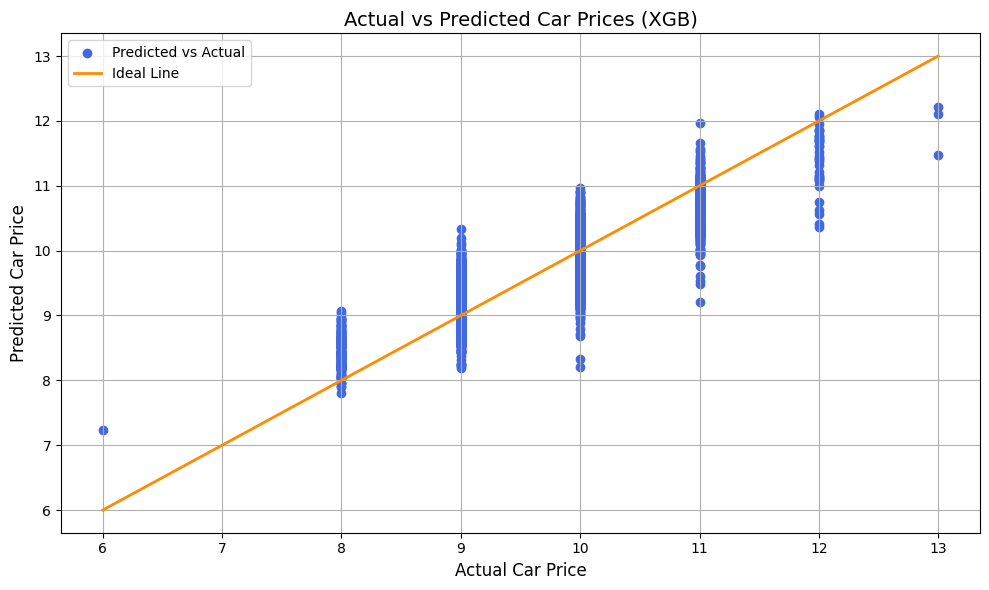

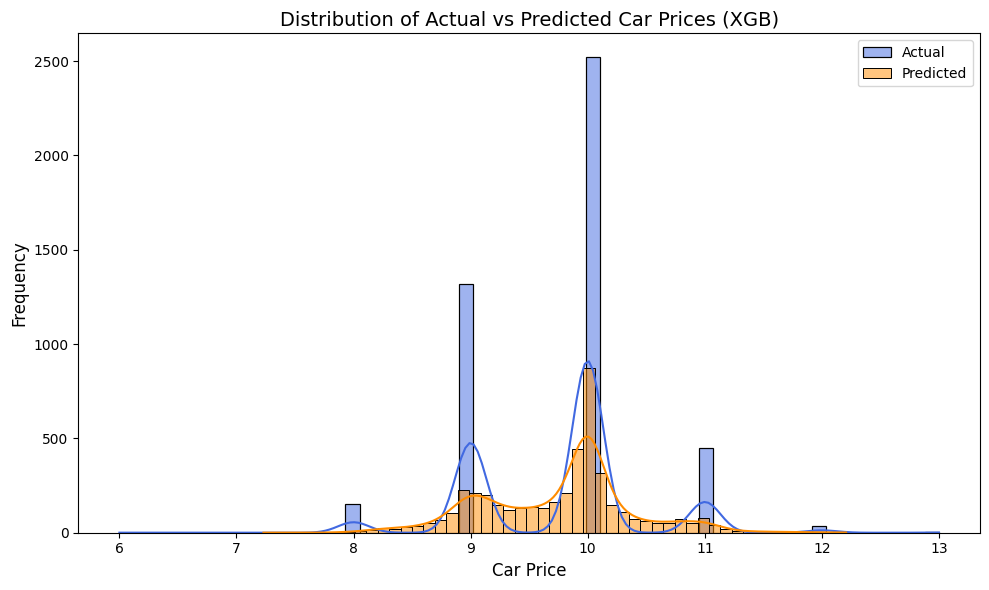

In [77]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Initialize XGBRegressor model
XGBModel = XGBRegressor(learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8, random_state=0)

# Backward Elimination Function
def backward_elimination(X_train, y_train, X_test, y_test, model, min_features=35):
    features = X_train.columns.tolist()
    while len(features) > min_features:
        # Fit the model with the current set of features
        model.fit(X_train[features], y_train)
        
        # Predict and evaluate the model performance
        y_pred = model.predict(X_test[features])
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        print(f'Current MSE: {mse}, R2: {r2}, Features Remaining: {len(features)}')
        
        # Get the feature importances and sort them
        feature_importances = model.feature_importances_
        feature_importances_df = pd.DataFrame({
            'Feature': features,
            'Importance': feature_importances
        }).sort_values(by='Importance', ascending=True)
        
        # Remove the least important feature
        least_important_feature = feature_importances_df.iloc[0]['Feature']
        features.remove(least_important_feature)
        
        print(f'Removed Feature: {least_important_feature}')
    
    # Final model with the remaining features
    final_model = model.fit(X_train[features], y_train)
    y_pred_final = final_model.predict(X_test[features])
    
    final_mse = mean_squared_error(y_test, y_pred_final)
    final_r2 = r2_score(y_test, y_pred_final)
    
    print(f'\nFinal MSE: {final_mse}, \nFinal R2: {final_r2}, \nFinal Features: {features}')

    # Scatter plot of Actual vs. Predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred_final, color='royalblue', label='Predicted vs Actual')
    
    # Plot the ideal line (y_pred = y_actual) for reference
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='darkorange', linewidth=2, label='Ideal Line')
    
    # Adding labels and title
    plt.title('Actual vs Predicted Car Prices (XGB)', fontsize=14)
    plt.xlabel('Actual Car Price', fontsize=12)
    plt.ylabel('Predicted Car Price', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))

    # Plot distribution of Actual vs. Predicted values
    sns.histplot(y_test, color='royalblue', label='Actual', kde=True)
    sns.histplot(y_pred_final, color='darkorange', label='Predicted', kde=True)
    
    # Adding labels and title
    plt.title('Distribution of Actual vs Predicted Car Prices (XGB)', fontsize=14)
    plt.xlabel('Car Price', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return final_model, features

# Apply Backward Elimination
final_model, selected_features = backward_elimination(X_train, y_train, X_test, y_test, XGBModel)